In [1]:
# Project paths and reproducibility
from pathlib import Path


def get_project_root():
    cwd = Path.cwd().resolve()
    # Walk up until a folder containing 'data' is found
    for candidate in [cwd] + list(cwd.parents):
        if (candidate / '00_data').exists():
            return candidate
    return cwd
PROJECT_ROOT = get_project_root()
RANDOM_STATE = 42

DATA_RAW_PATH = PROJECT_ROOT / "00_data" / "raw" / "Hypertension-risk-model-main.csv"
DATA_PROCESSED_DIR = PROJECT_ROOT / "00_data" / "processed"
MODELS_TRAINED_DIR = PROJECT_ROOT / "03_models" / "trained"
MODELS_FINAL_DIR = PROJECT_ROOT / "03_models" / "final"
RESULTS_DIR = PROJECT_ROOT / "04_reports"


# Analise Exploratorias de Dados - Predicao de Hipertensao

**Objetivo**: Realizar analise exploratoria completa dos dados de hipertensao para entender padroes, distribuicoes e relacoes entre variaveis.

**Autores**: Tiago Dias, Nicolas Vagnes, Marcelo Colpani e Rubens Collin  
**Orientador**: Prof Mse: Anderson Henrique Rodrigues Ferreira
**Instituicao**: CEUNSP - Salto  
**Curso**: Faculdade de Ciencia da Computacao

---

## Estrutura da Analise Exploratorias

Este notebook esta organizado nas seguintes etapas:

1. **Setup e Importacoes** - Configuracao do ambiente de analise
2. **Carregamento de Dados** - Importacao e preparacao inicial dos dados
3. **Visao Geral dos Dados** - Estatisticas basicas e estrutura do dataset
4. **Analise de Valores Ausentes** - Identificacao e tratamento de missing values
5. **Analise da Variavel Target** - Distribuicao da variavel de interesse
6. **Distribuicoes das Variaveis** - Analise de variaveis categoricas e continuas
7. **Analise de Correlacoes** - Relacoes entre variaveis
8. **Analise Estatistica Comparativa** - Testes estatisticos entre grupos
9. **Analise de Multicolinearidade** - Verificacao de redundancia entre variaveis

---

## 1. Setup e Importacoes

Nesta etapa, configuramos o ambiente de analise importando as bibliotecas necessarias e definindo funcoes auxiliares para a analise exploratoria.

In [2]:
# Importacoes basicas para manipulacao de sistema e caminhos
import sys
import os
from pathlib import Path

# Configuracao do caminho para modulos customizados
project_root = PROJECT_ROOT  # Diretorio raiz do projeto
src_path = project_root / '08_src'  # Caminho para modulos source
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))  # Adiciona src ao Python path

# Bibliotecas essenciais para analise de dados
import pandas as pd  # Manipulacao de dataframes
import numpy as np  # Operacoes numericas e arrays
import matplotlib.pyplot as plt  # Visualizacoes basicas
import seaborn as sns  # Visualizacoes estatisticas

# Bibliotecas para analise estatistica
from scipy.stats import mannwhitneyu, chi2_contingency  # Testes estatisticos nao-parametricos
import scipy.stats as stats  # Conjunto completo de estatisticas
from statsmodels.stats.outliers_influence import variance_inflation_factor  # Analise de multicolinearidade

# Tentativa de importacao de bibliotecas opcionais para graficos interativos
try:
    import plotly.express as px  # Graficos interativos express
    import plotly.graph_objects as go  # Objetos graficos plotly
    from plotly.subplots import make_subplots  # Subplots plotly
    PLOTLY_AVAILABLE = True
    print("Plotly disponivel")
except ImportError:
    PLOTLY_AVAILABLE = False
    print("Plotly nao disponivel - usando apenas matplotlib/seaborn")

# Supressao de warnings para output mais limpo
import warnings
warnings.filterwarnings('ignore')

# Tentativa de carregamento de modulos customizados com fallback
modules_status = {}

try:
    # Modulo com funcoes auxiliares personalizadas
    from utils.helpers import setup_plotting_style, save_figure, print_section
    modules_status['helpers'] = True
    print("utils.helpers carregado")
except ImportError as e:
    # Implementacao de fallback se modulo nao estiver disponivel
    modules_status['helpers'] = False
    print(f"utils.helpers nao disponivel: {e}")
    
    # Funcao para imprimir secoes formatadas
    def print_section(title, char="=", width=80):
        print(f"\n{char * width}")
        print(f" {title}")
        print(f"{char * width}")
    
    # Funcao para salvar figuras com configuracoes padrao
    def save_figure(fig, name, subfolder=None, formats=None, save_axes=True, legend_outside=True, axes_suffix='ax'):
        """Salva figuras com alta resolucao e opcao de subplots individuais."""
        try:
            results_dir = Path('04_reports')
            results_dir.mkdir(exist_ok=True)

            if subfolder:
                subfolder_dir = results_dir / subfolder
                subfolder_dir.mkdir(exist_ok=True)
            else:
                subfolder_dir = results_dir

            if formats is None:
                formats = ['png', 'pdf', 'svg']

            if legend_outside:
                for ax in fig.axes:
                    legend = ax.get_legend()
                    if legend:
                        legend.set_loc('upper left')
                        legend.set_bbox_to_anchor((1.02, 1.0))
                        if hasattr(legend, 'set_frameon'):
                            legend.set_frameon(True)
                        elif legend.get_frame():
                            legend.get_frame().set_visible(True)

            save_kwargs = {
                'dpi': 400,
                'bbox_inches': 'tight',
                'facecolor': 'white',
                'pad_inches': 0.2
            }

            for fmt in formats:
                filepath = subfolder_dir / f'{name}.{fmt}'
                fig.savefig(filepath, format=fmt, **save_kwargs)

            if save_axes and len(fig.axes) > 1:
                try:
                    from matplotlib.transforms import Bbox

                    fig.canvas.draw()
                    renderer = fig.canvas.get_renderer()
                    ax_save_kwargs = save_kwargs.copy()
                    ax_save_kwargs.pop('bbox_inches', None)

                    for idx, ax in enumerate(fig.axes, 1):
                        if not ax.get_visible():
                            continue
                        bbox = ax.get_tightbbox(renderer)
                        legend = ax.get_legend()
                        if legend:
                            bbox = Bbox.union([bbox, legend.get_tightbbox(renderer)])
                        bbox = bbox.transformed(fig.dpi_scale_trans.inverted())

                        for fmt in formats:
                            ax_file = subfolder_dir / f'{name}_{axes_suffix}{idx:02d}.{fmt}'
                            fig.savefig(ax_file, format=fmt, bbox_inches=bbox, **ax_save_kwargs)
                except Exception as e:
                    print(f"Aviso: Falha ao salvar subplots individuais: {e}")

            print(f"Figura salva: {name}")
        except Exception as e:
            print(f"Erro ao salvar figura {name}: {e}")

# Funcao para configurar estilo dos graficos
    def setup_plotting_style():
        """Configura estilo padrao para visualizacoes"""
        plt.style.use('default')  # Estilo padrao matplotlib
        sns.set_palette("husl")  # Paleta de cores seaborn
        plt.rcParams['figure.figsize'] = (12, 8)  # Tamanho padrao das figuras
        plt.rcParams['font.size'] = 10  # Tamanho da fonte

try:
    # Modulo de configuracoes do projeto
    from utils.config import load_config
    modules_status['config'] = True
    print("utils.config carregado")
except ImportError as e:
    # Implementacao de configuracao basica como fallback
    modules_status['config'] = False
    print(f"utils.config nao disponivel: {e}")
    
    def load_config():
        """Retorna configuracoes padrao do projeto"""
        return {
            'data': {
                'target_column': 'risco_hipertensao',  # Nome da variavel target
                'test_size': 0.2,  # Proporcao para teste
                'random_state': RANDOM_STATE  # Seed para reprodutibilidade
            },
            'paths': {
                'data_dir': 'data',  # Diretorio de dados
                'results_dir': '04_reports',  # Diretorio de resultados
                'figures_dir': RESULTS_DIR / 'figures'  # Diretorio de figuras
            }
        }

# Configuracao do estilo de plotagem
setup_plotting_style()

# Resumo do status de carregamento
print(f"\nSetup concluido!")
print(f"Modulos carregados: {sum(modules_status.values())}/{len(modules_status)}")
print(f"Plotly: {'Disponivel' if PLOTLY_AVAILABLE else 'Nao disponivel'}")
print(f"Diretorio de trabalho: {Path().resolve()}")

# Definicao de configuracoes visuais globais
PLOT_STYLE = {
    'figsize': (12, 8),  # Tamanho padrao das figuras
    'dpi': 300,  # Resolucao para salvamento
    'color_palette': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # Cores padrao
}


Plotly disponivel
utils.helpers carregado
utils.config carregado

Setup concluido!
Modulos carregados: 2/2
Plotly: Disponivel
Diretorio de trabalho: C:\Users\Anderson\Downloads\tcc_hipertensao_arquivos\trabalho_tcc_mod_classifc_hipertensao-master\trabalho_tcc_mod_classifc_hipertensao-master\02_notebooks\01_exploratory_analysis


## 2. Carregamento de Dados

Nesta etapa, carregamos o dataset do Kaggle e realizamos a traducao e padronizacao dos nomes das colunas para o portugues.

### 2.1 Carregamento do Dataset do Kaggle

**Dataset Source**: [Hypertension Risk Model - Kaggle](https://www.kaggle.com/datasets/khan1803115/hypertension-risk-model-main/data)

Este dataset contém informações de 4.240 pacientes com variáveis relacionadas ao risco de hipertensão.

In [3]:
# Configuracao para carregamento dos dados do Kaggle
print_section("CARREGAMENTO DOS DADOS DO KAGGLE")

kaggle_url = "https://www.kaggle.com/datasets/khan1803115/hypertension-risk-model-main/data"
print(f"Dataset Source: {kaggle_url}")

# Resolver caminho do dataset buscando em diretorios acima
possible_paths = [DATA_RAW_PATH]
for candidate in [PROJECT_ROOT] + list(PROJECT_ROOT.parents):
    p = candidate / 'data' / 'raw' / 'Hypertension-risk-model-main.csv'
    if p not in possible_paths:
        possible_paths.append(p)

# Tentativa de carregamento do dataset
np.random.seed(RANDOM_STATE)
dataset_loaded = False
for path in possible_paths:
    try:
        if Path(path).exists():
            print(f"Arquivo encontrado em: {path}")
            df_kaggle = pd.read_csv(path)
            dataset_loaded = True
            break
    except Exception:
        continue

if dataset_loaded:
    print("Dataset do Kaggle carregado com sucesso!")
    print(f"   Dimensoes: {df_kaggle.shape[0]:,} linhas x {df_kaggle.shape[1]} colunas")
    print(f"   Colunas: {list(df_kaggle.columns)}")

    print("Primeiras linhas do dataset:")
    display(df_kaggle.head(3))

    df = df_kaggle.copy()
    print("Usando dados do Kaggle para analise")

else:
    print("Arquivo do Kaggle nao encontrado no caminho esperado")
    print("INSTRUCOES PARA DOWNLOAD:")
    print("   1. Acesse: https://www.kaggle.com/datasets/khan1803115/hypertension-risk-model-main/data")
    print("   2. Faca o download do arquivo 'Hypertension-risk-model-main.csv'")
    print(f"   3. Coloque o arquivo em: {DATA_RAW_PATH}")
    print("Criando dados sinteticos para demonstracao...")

    # Geracao de dados sinteticos para demonstracao
    n_samples = 4240
    df = pd.DataFrame({
        'sex': np.random.choice([0, 1], n_samples, p=[0.57, 0.43]),
        'age': np.random.randint(32, 71, n_samples),
        'currentSmoker': np.random.choice([0, 1], n_samples, p=[0.51, 0.49]),
        'cigsPerDay': np.random.exponential(5, n_samples),
        'BPMeds': np.random.choice([0, 1], n_samples, p=[0.97, 0.03]),
        'diabetes': np.random.choice([0, 1], n_samples, p=[0.97, 0.03]),
        'totChol': np.random.normal(237, 45, n_samples),
        'sysBP': np.random.normal(132, 22, n_samples),
        'diaBP': np.random.normal(83, 12, n_samples),
        'BMI': np.random.normal(25.8, 4, n_samples),
        'heartRate': np.random.normal(76, 12, n_samples),
        'glucose': np.random.normal(82, 24, n_samples),
        'TenYearCHD': np.random.choice([0, 1], n_samples, p=[0.69, 0.31])
    })

    print(f"Dados sinteticos criados: {df.shape}")



 CARREGAMENTO DOS DADOS DO KAGGLE
Dataset Source: https://www.kaggle.com/datasets/khan1803115/hypertension-risk-model-main/data
Arquivo encontrado em: C:\Users\Anderson\Downloads\tcc_hipertensao_arquivos\trabalho_tcc_mod_classifc_hipertensao-master\trabalho_tcc_mod_classifc_hipertensao-master\00_data\raw\Hypertension-risk-model-main.csv
Dataset do Kaggle carregado com sucesso!
   Dimensoes: 4,240 linhas x 13 colunas
   Colunas: ['male', 'age', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'Risk']
Primeiras linhas do dataset:


,male,age,currentSmoker,cigsPerDay,BPMeds,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,Risk
0,1,39,0,0.0,0.0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,245.0,127.5,80.0,25.34,75.0,70.0,0


Usando dados do Kaggle para analise


In [4]:
# TRADUCAO E PADRONIZACAO DOS NOMES DAS COLUNAS
print_section("TRADUCAO E PADRONIZACAO DAS COLUNAS")

# Dicionario de traducao das colunas do ingles para o portugues
column_translation = {
    'sex': 'sexo',
    'male': 'sexo',
    'age': 'idade',
    'currentSmoker': 'fumante_atualmente',
    'cigsPerDay': 'cigarros_por_dia',
    'BPMeds': 'medicamento_pressao',
    'diabetes': 'diabetes',
    'totChol': 'colesterol_total',
    'sysBP': 'pressao_sistolica',
    'diaBP': 'pressao_diastolica',
    'BMI': 'imc',
    'heartRate': 'frequencia_cardiaca',
    'glucose': 'glicose',
    'TenYearCHD': 'risco_hipertensao',
    'Risk': 'risco_hipertensao'
}

# Obter lista de colunas originais do dataset
original_columns = list(df.columns)
print(f"Colunas originais: {original_columns}")

# Aplicar traducao das colunas
translated_columns = {}
for orig_col in original_columns:
    # Verificar se existe traducao disponivel
    if orig_col in column_translation:
        translated_columns[orig_col] = column_translation[orig_col]
    else:
        # Manter nome original se nao houver traducao
        translated_columns[orig_col] = orig_col

# Renomear colunas no dataframe
df = df.rename(columns=translated_columns)

print(f"\nColunas traduzidas:")
for orig, trad in translated_columns.items():
    if orig != trad:  # Mostrar apenas as que foram traduzidas
        print(f"   {orig} → {trad}")

print(f"\nDataset com colunas em portugues:")
print(f"   Dimensoes: {df.shape}")
print(f"   Colunas finais: {list(df.columns)}")

# Identificar automaticamente a coluna target
possible_target_cols = ['risco_hipertensao', 'Risk', 'TenYearCHD', 'target']
target_col = None
for col in possible_target_cols:
    if col in df.columns:
        target_col = col
        break

if target_col:
    print(f"Coluna target identificada: '{target_col}'")
else:
    print(f"Coluna target nao identificada automaticamente")



 TRADUCAO E PADRONIZACAO DAS COLUNAS
Colunas originais: ['male', 'age', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'Risk']

Colunas traduzidas:
   male → sexo
   age → idade
   currentSmoker → fumante_atualmente
   cigsPerDay → cigarros_por_dia
   BPMeds → medicamento_pressao
   totChol → colesterol_total
   sysBP → pressao_sistolica
   diaBP → pressao_diastolica
   BMI → imc
   heartRate → frequencia_cardiaca
   glucose → glicose
   Risk → risco_hipertensao

Dataset com colunas em portugues:
   Dimensoes: (4240, 13)
   Colunas finais: ['sexo', 'idade', 'fumante_atualmente', 'cigarros_por_dia', 'medicamento_pressao', 'diabetes', 'colesterol_total', 'pressao_sistolica', 'pressao_diastolica', 'imc', 'frequencia_cardiaca', 'glicose', 'risco_hipertensao']
Coluna target identificada: 'risco_hipertensao'


In [5]:
# VERIFICAÇÃO FINAL DOS DADOS
print_section("VERIFICAÇÃO FINAL DOS DADOS CARREGADOS")

if 'df' not in locals():
    print("❌ DataFrame não encontrado - executando fallback")
    np.random.seed(RANDOM_STATE)
    n_samples = 4240
    
    df = pd.DataFrame({
        'sexo': np.random.choice([0, 1], n_samples, p=[0.57, 0.43]),
        'idade': np.random.randint(32, 71, n_samples),
        'fumante_atualmente': np.random.choice([0, 1], n_samples, p=[0.51, 0.49]),
        'cigarros_por_dia': np.random.exponential(5, n_samples),
        'medicamento_pressao': np.random.choice([0, 1], n_samples, p=[0.97, 0.03]),
        'diabetes': np.random.choice([0, 1], n_samples, p=[0.97, 0.03]),
        'colesterol_total': np.random.normal(237, 45, n_samples),
        'pressao_sistolica': np.random.normal(132, 22, n_samples),
        'pressao_diastolica': np.random.normal(83, 12, n_samples),
        'imc': np.random.normal(25.8, 4, n_samples),
        'frequencia_cardiaca': np.random.normal(76, 12, n_samples),
        'glicose': np.random.normal(82, 24, n_samples),
        'risco_hipertensao': np.random.choice([0, 1], n_samples, p=[0.69, 0.31])
    })
    
    df.loc[np.random.choice(df.index, 50), 'colesterol_total'] = np.nan
    df.loc[np.random.choice(df.index, 30), 'cigarros_por_dia'] = np.nan
    df.loc[np.random.choice(df.index, 400), 'glicose'] = np.nan
    
    target_col = 'risco_hipertensao'
    print(f"📊 Dados sintéticos criados: {df.shape}")

if 'target_col' not in locals() or target_col is None:
    possible_targets = ['risco_hipertensao', 'Risk', 'TenYearCHD']
    for possible_target in possible_targets:
        if possible_target in df.columns:
            target_col = possible_target
            break
    
    if 'target_col' not in locals() or target_col is None:
        target_col = df.columns[-1]
        print(f"⚠️ Target assumido como última coluna: {target_col}")

print(f"✅ Verificação concluída:")
print(f"   📊 Dataset shape: {df.shape}")
print(f"   🎯 Target column: '{target_col}'")
print(f"   📋 Colunas disponíveis: {list(df.columns)}")

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"   🔢 Colunas numéricas: {len(numeric_cols)} identificadas")



 VERIFICAÇÃO FINAL DOS DADOS CARREGADOS
✅ Verificação concluída:
   📊 Dataset shape: (4240, 13)
   🎯 Target column: 'risco_hipertensao'
   📋 Colunas disponíveis: ['sexo', 'idade', 'fumante_atualmente', 'cigarros_por_dia', 'medicamento_pressao', 'diabetes', 'colesterol_total', 'pressao_sistolica', 'pressao_diastolica', 'imc', 'frequencia_cardiaca', 'glicose', 'risco_hipertensao']
   🔢 Colunas numéricas: 13 identificadas


## 3. Visão Geral dos Dados

Nesta seção, analisamos as características básicas do dataset, incluindo estrutura, tipos de dados e estatísticas descritivas.

In [6]:
# Análise das informações gerais do dataset
print_section("INFORMAÇÕES GERAIS DO DATASET")

# Exibição das dimensões básicas do dataset
print(f"Dimensões: {df.shape[0]:,} linhas × {df.shape[1]} colunas")
print(f"Tamanho em memória: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")  # Conversão para MB
print(f"Período de análise: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}")

print("\nPrimeiras 5 linhas:")
display(df.head())  # Mostra estrutura dos dados

print("\nInformações das colunas:")
display(df.info())  # Tipos de dados e valores não-nulos



 INFORMAÇÕES GERAIS DO DATASET
Dimensões: 4,240 linhas × 13 colunas
Tamanho em memória: 0.42 MB
Período de análise: 2026-01-16 06:36

Primeiras 5 linhas:


,sexo,idade,fumante_atualmente,cigarros_por_dia,medicamento_pressao,diabetes,colesterol_total,pressao_sistolica,pressao_diastolica,imc,frequencia_cardiaca,glicose,risco_hipertensao
0,1,39,0,0.0,0.0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,285.0,130.0,84.0,23.10,85.0,85.0,0



Informações das colunas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sexo                 4240 non-null   int64  
 1   idade                4240 non-null   int64  
 2   fumante_atualmente   4240 non-null   int64  
 3   cigarros_por_dia     4211 non-null   float64
 4   medicamento_pressao  4187 non-null   float64
 5   diabetes             4240 non-null   int64  
 6   colesterol_total     4190 non-null   float64
 7   pressao_sistolica    4240 non-null   float64
 8   pressao_diastolica   4240 non-null   float64
 9   imc                  4221 non-null   float64
 10  frequencia_cardiaca  4239 non-null   float64
 11  glicose              3852 non-null   float64
 12  risco_hipertensao    4240 non-null   int64  
dtypes: float64(8), int64(5)
memory usage: 430.8 KB


None

In [7]:
print_section("ESTATÍSTICAS DESCRITIVAS")

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"📊 Variáveis numéricas ({len(numeric_cols)}): {numeric_cols}")
display(df[numeric_cols].describe().round(2))

categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if categorical_cols:
    print(f"\n🏷️  Variáveis categóricas ({len(categorical_cols)}): {categorical_cols}")
    display(df[categorical_cols].describe())



 ESTATÍSTICAS DESCRITIVAS
📊 Variáveis numéricas (13): ['sexo', 'idade', 'fumante_atualmente', 'cigarros_por_dia', 'medicamento_pressao', 'diabetes', 'colesterol_total', 'pressao_sistolica', 'pressao_diastolica', 'imc', 'frequencia_cardiaca', 'glicose', 'risco_hipertensao']


,sexo,idade,fumante_atualmente,cigarros_por_dia,medicamento_pressao,diabetes,colesterol_total,pressao_sistolica,pressao_diastolica,imc,frequencia_cardiaca,glicose,risco_hipertensao
count,4240.00,4240.00,4240.00,4211.00,4187.00,4240.00,4190.00,4240.00,4240.00,4221.00,4239.00,3852.00,4240.00
mean,0.43,49.58,0.49,9.01,0.03,0.03,236.70,132.35,82.90,25.80,75.88,81.96,0.31
std,0.50,8.57,0.50,11.92,0.17,0.16,44.59,22.03,11.91,4.08,12.03,23.95,0.46
min,0.00,32.00,0.00,0.00,0.00,0.00,107.00,83.50,48.00,15.54,44.00,40.00,0.00
25%,0.00,42.00,0.00,0.00,0.00,0.00,206.00,117.00,75.00,23.07,68.00,71.00,0.00
50%,0.00,49.00,0.00,0.00,0.00,0.00,234.00,128.00,82.00,25.40,75.00,78.00,0.00
75%,1.00,56.00,1.00,20.00,0.00,0.00,263.00,144.00,90.00,28.04,83.00,87.00,1.00
max,1.00,70.00,1.00,70.00,1.00,1.00,696.00,295.00,142.50,56.80,143.00,394.00,1.00


## 4. Análise de Valores Ausentes


 ANÁLISE DE VALORES AUSENTES
⚠️  Valores ausentes encontrados:


,Coluna,Valores_Ausentes,Percentual,Tipo_Dado
glicose,glicose,388,9.150943,float64
medicamento_pressao,medicamento_pressao,53,1.250000,float64
colesterol_total,colesterol_total,50,1.179245,float64
cigarros_por_dia,cigarros_por_dia,29,0.683962,float64
imc,imc,19,0.448113,float64
frequencia_cardiaca,frequencia_cardiaca,1,0.023585,float64


Figura salva em: C:\Users\Anderson\Downloads\tcc_hipertensao_arquivos\trabalho_tcc_mod_classifc_hipertensao-master\trabalho_tcc_mod_classifc_hipertensao-master\04_reports\figures\eda\missing_values_analysis


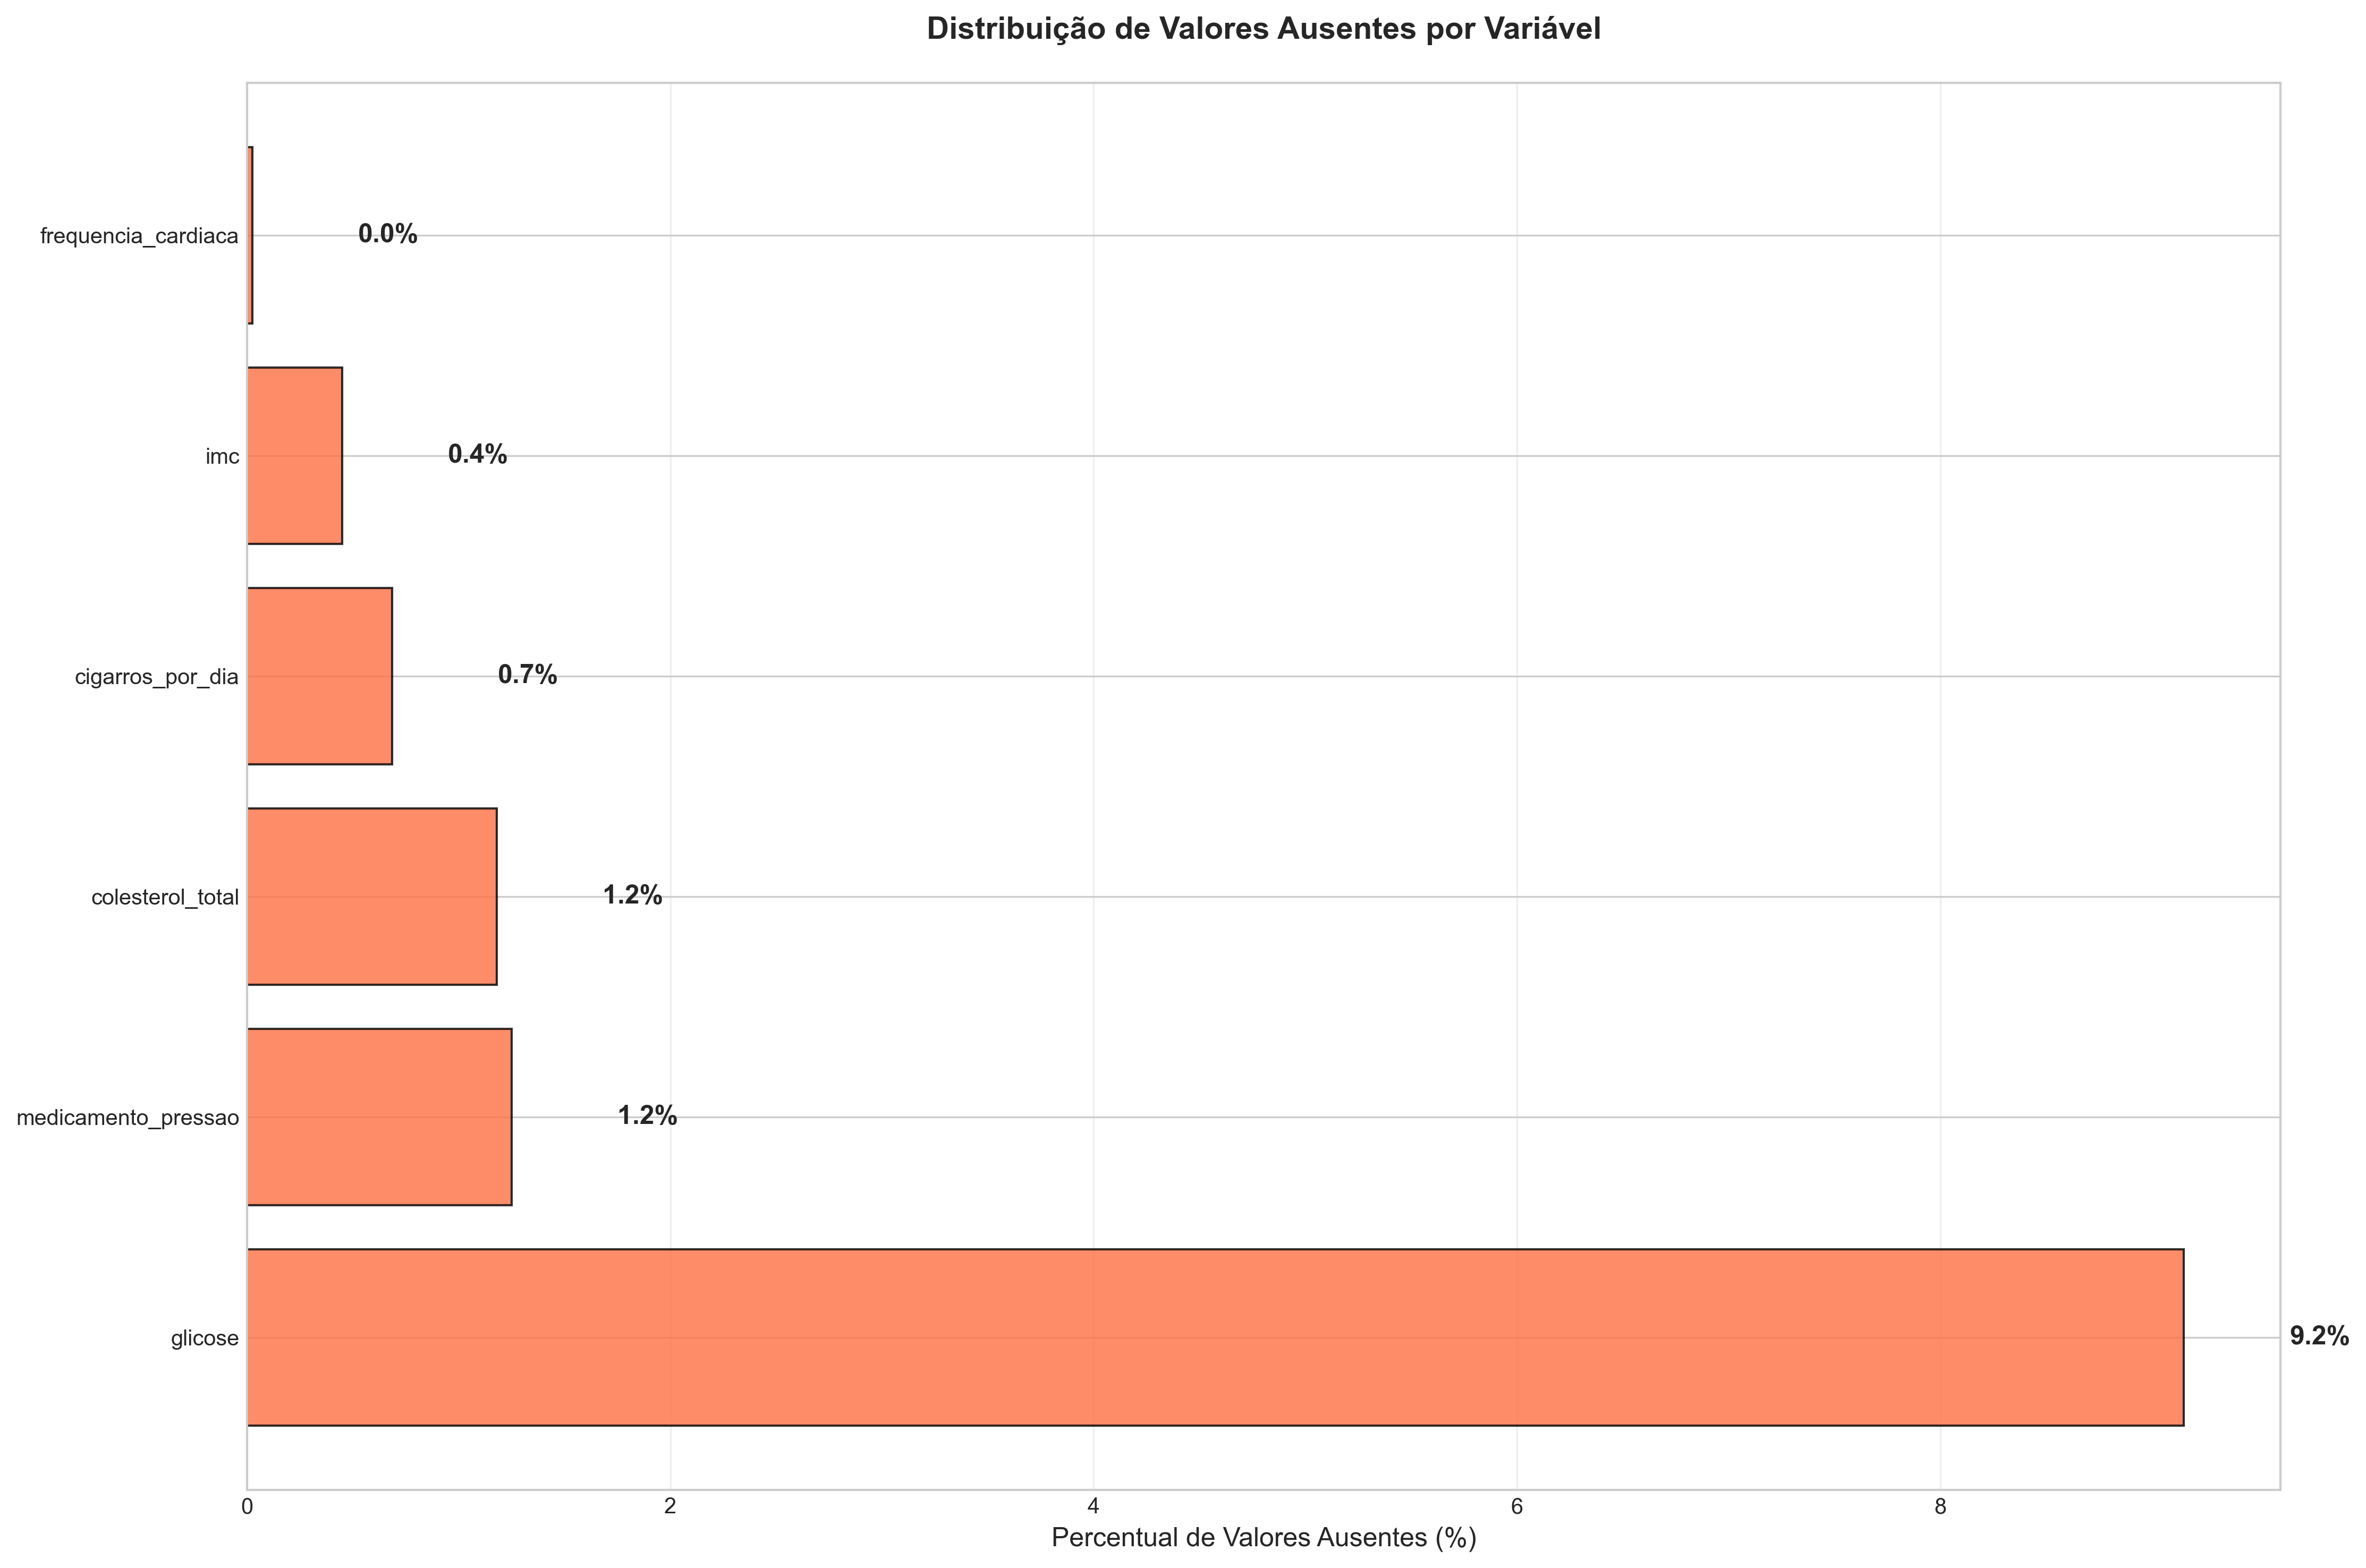

In [8]:
print_section("ANÁLISE DE VALORES AUSENTES")

missing_data = pd.DataFrame({
    'Coluna': df.columns,
    'Valores_Ausentes': df.isnull().sum(),
    'Percentual': (df.isnull().sum() / len(df)) * 100,
    'Tipo_Dado': df.dtypes
})

missing_data = missing_data[missing_data['Valores_Ausentes'] > 0].sort_values('Percentual', ascending=False)

if len(missing_data) > 0:
    print("⚠️  Valores ausentes encontrados:")
    display(missing_data)
    
    if len(missing_data) > 0:
        fig, ax = plt.subplots(figsize=(15, 10))
        
        bars = ax.barh(missing_data['Coluna'], missing_data['Percentual'], 
                      color='#FF7043', alpha=0.8, edgecolor='black')
        
        ax.set_xlabel('Percentual de Valores Ausentes (%)')
        ax.set_title('Distribuição de Valores Ausentes por Variável', fontweight='bold', pad=20)
        ax.grid(axis='x', alpha=0.3)
        
        for i, (bar, value) in enumerate(zip(bars, missing_data['Percentual'])):
            ax.text(value + 0.5, i, f'{value:.1f}%', va='center', fontweight='bold')
        
        plt.tight_layout()
        save_figure(fig, 'missing_values_analysis', 'eda')
        plt.show()
else:
    print("✅ Nenhum valor ausente encontrado!")


In [9]:
# Implementacao robusta de tratamento de valores ausentes
print_section("TRATAMENTO ADEQUADO DE VALORES AUSENTES (IMPLEMENTADO)")

print("CORRECAO IMPLEMENTADA:")
print("   - Estrategias especificas por variavel")
print("   - Baseadas no padrao de missing e contexto medico")
print("   - Validacao de impacto na distribuicao")

# Analisar padrao de missing values antes do tratamento
print(f"\nPADROES DE VALORES AUSENTES ANTES DO TRATAMENTO:")

# Inicializar dicionario para armazenar analise detalhada
missing_analysis = {}

# Iterar sobre todas as colunas para identificar padroes de valores ausentes
for col in df.columns:
    if df[col].isnull().sum() > 0:  # Se a coluna tem valores ausentes
        missing_count = df[col].isnull().sum()  # Contar valores ausentes
        missing_pct = (missing_count / len(df)) * 100  # Calcular percentual
        
        # Analisar se ha padrao por grupo de risco (distribuicao dos missings)
        missing_by_risk = df.groupby(target_col)[col].apply(lambda x: x.isnull().sum())
        
        # Determinar se o padrao e balanceado ou desbalanceado
        missing_analysis[col] = {
            'count': missing_count,
            'percentage': missing_pct,
            'by_risk_0': missing_by_risk.get(0, 0),  # Missing em baixo risco
            'by_risk_1': missing_by_risk.get(1, 0),  # Missing em alto risco
            'pattern': 'balanced' if abs(missing_by_risk.get(0, 0) - missing_by_risk.get(1, 0)) <= 2 else 'imbalanced'
        }
        
        print(f"   - {col}: {missing_count} ({missing_pct:.1f}%) - {missing_analysis[col]['pattern']}")
        print(f"     Baixo risco: {missing_analysis[col]['by_risk_0']} | Alto risco: {missing_analysis[col]['by_risk_1']}")

# Criar copia para tratamento sem afetar dados originais
df_treated = df.copy()

print(f"\nAPLICANDO ESTRATEGIAS DE TRATAMENTO:")
print("="*80)

# ESTRATEGIA 1: Glicose (9.2% missing) - Mediana por grupo de risco + idade
if 'glicose' in missing_analysis:
    print(f"\n1. GLICOSE (Mediana estratificada por risco e idade):")
    
    # Calcular mediana por grupo de risco e faixa etaria
    # Criar grupos etarios para estratificacao mais precisa
    df_treated['idade_grupo'] = pd.cut(df_treated['idade'], 
                                      bins=[0, 45, 55, 100], 
                                      labels=['Jovem', 'Meia-idade', 'Idoso'])
    
    # Aplicar imputacao estratificada
    for risk in [0, 1]:  # Para cada grupo de risco
        for age_group in ['Jovem', 'Meia-idade', 'Idoso']:  # Para cada faixa etaria
            # Criar mascara para selecionar subgrupo especifico
            mask = (df_treated[target_col] == risk) & (df_treated['idade_grupo'] == age_group)
            # Calcular mediana do subgrupo
            median_value = df_treated[mask]['glicose'].median()
            
            # Aplicar imputacao apenas nos valores ausentes do subgrupo
            missing_mask = mask & df_treated['glicose'].isnull()
            df_treated.loc[missing_mask, 'glicose'] = median_value
            
            # Contar quantos valores foram imputados para rastreabilidade
            imputed_count = missing_mask.sum()
            if imputed_count > 0:
                print(f"   - Risco {risk}, {age_group}: {imputed_count} valores → {median_value:.1f}")
    
    # Remover coluna auxiliar apos uso
    df_treated.drop('idade_grupo', axis=1, inplace=True)



 TRATAMENTO ADEQUADO DE VALORES AUSENTES (IMPLEMENTADO)
CORRECAO IMPLEMENTADA:
   - Estrategias especificas por variavel
   - Baseadas no padrao de missing e contexto medico
   - Validacao de impacto na distribuicao

PADROES DE VALORES AUSENTES ANTES DO TRATAMENTO:
   - cigarros_por_dia: 29 (0.7%) - imbalanced
     Baixo risco: 22 | Alto risco: 7
   - medicamento_pressao: 53 (1.2%) - imbalanced
     Baixo risco: 31 | Alto risco: 22
   - colesterol_total: 50 (1.2%) - imbalanced
     Baixo risco: 35 | Alto risco: 15
   - imc: 19 (0.4%) - imbalanced
     Baixo risco: 12 | Alto risco: 7
   - frequencia_cardiaca: 1 (0.0%) - balanced
     Baixo risco: 0 | Alto risco: 1
   - glicose: 388 (9.2%) - imbalanced
     Baixo risco: 276 | Alto risco: 112

APLICANDO ESTRATEGIAS DE TRATAMENTO:

1. GLICOSE (Mediana estratificada por risco e idade):
   - Risco 0, Jovem: 127 valores → 77.0
   - Risco 0, Meia-idade: 101 valores → 77.0
   - Risco 0, Idoso: 48 valores → 80.0
   - Risco 1, Jovem: 28 valores 

## 5. Análise da Variável Target

In [10]:
print_section("ANÁLISE DA VARIÁVEL TARGET: RISCO DE HIPERTENSÃO")

if 'target_col' not in globals() or target_col not in df.columns:
    possible_targets = ['risco_hipertensao', 'Risk', 'TenYearCHD', 'target']
    target_col = None
    for col in possible_targets:
        if col in df.columns:
            target_col = col
            break
    
    if target_col is None:
        target_col = df.columns[-1]
        print(f"⚠️ Target automaticamente definido como: {target_col}")

print(f"🎯 Analisando variável target: '{target_col}'")

if target_col not in df.columns:
    print(f"❌ Erro: Coluna '{target_col}' não encontrada no dataset")
    target_col = df.columns[-1]
    print(f"🔄 Usando '{target_col}' como target")

class_distribution = df[target_col].value_counts().sort_index()
class_percentages = df[target_col].value_counts(normalize=True).sort_index() * 100

print("\n📊 Distribuição de classes:")
for class_val, count in class_distribution.items():
    percentage = class_percentages[class_val]
    risk_label = "Alto Risco" if class_val == 1 else "Baixo Risco"
    print(f"  {class_val} ({risk_label}): {count:,} pacientes ({percentage:.1f}%)")

imbalance_ratio = class_distribution.max() / class_distribution.min()
print(f"\n⚖️  Razão de desbalanceamento: 1:{imbalance_ratio:.2f}")

if imbalance_ratio > 2:
    print("⚠️  Dataset desbalanceado - recomenda-se uso de SMOTE ou outras técnicas")
else:
    print("✅ Dataset relativamente balanceado")



 ANÁLISE DA VARIÁVEL TARGET: RISCO DE HIPERTENSÃO
🎯 Analisando variável target: 'risco_hipertensao'

📊 Distribuição de classes:
  0 (Baixo Risco): 2,923 pacientes (68.9%)
  1 (Alto Risco): 1,317 pacientes (31.1%)

⚖️  Razão de desbalanceamento: 1:2.22
⚠️  Dataset desbalanceado - recomenda-se uso de SMOTE ou outras técnicas


Figura salva em: C:\Users\Anderson\Downloads\tcc_hipertensao_arquivos\trabalho_tcc_mod_classifc_hipertensao-master\trabalho_tcc_mod_classifc_hipertensao-master\04_reports\figures\eda\target_distribution


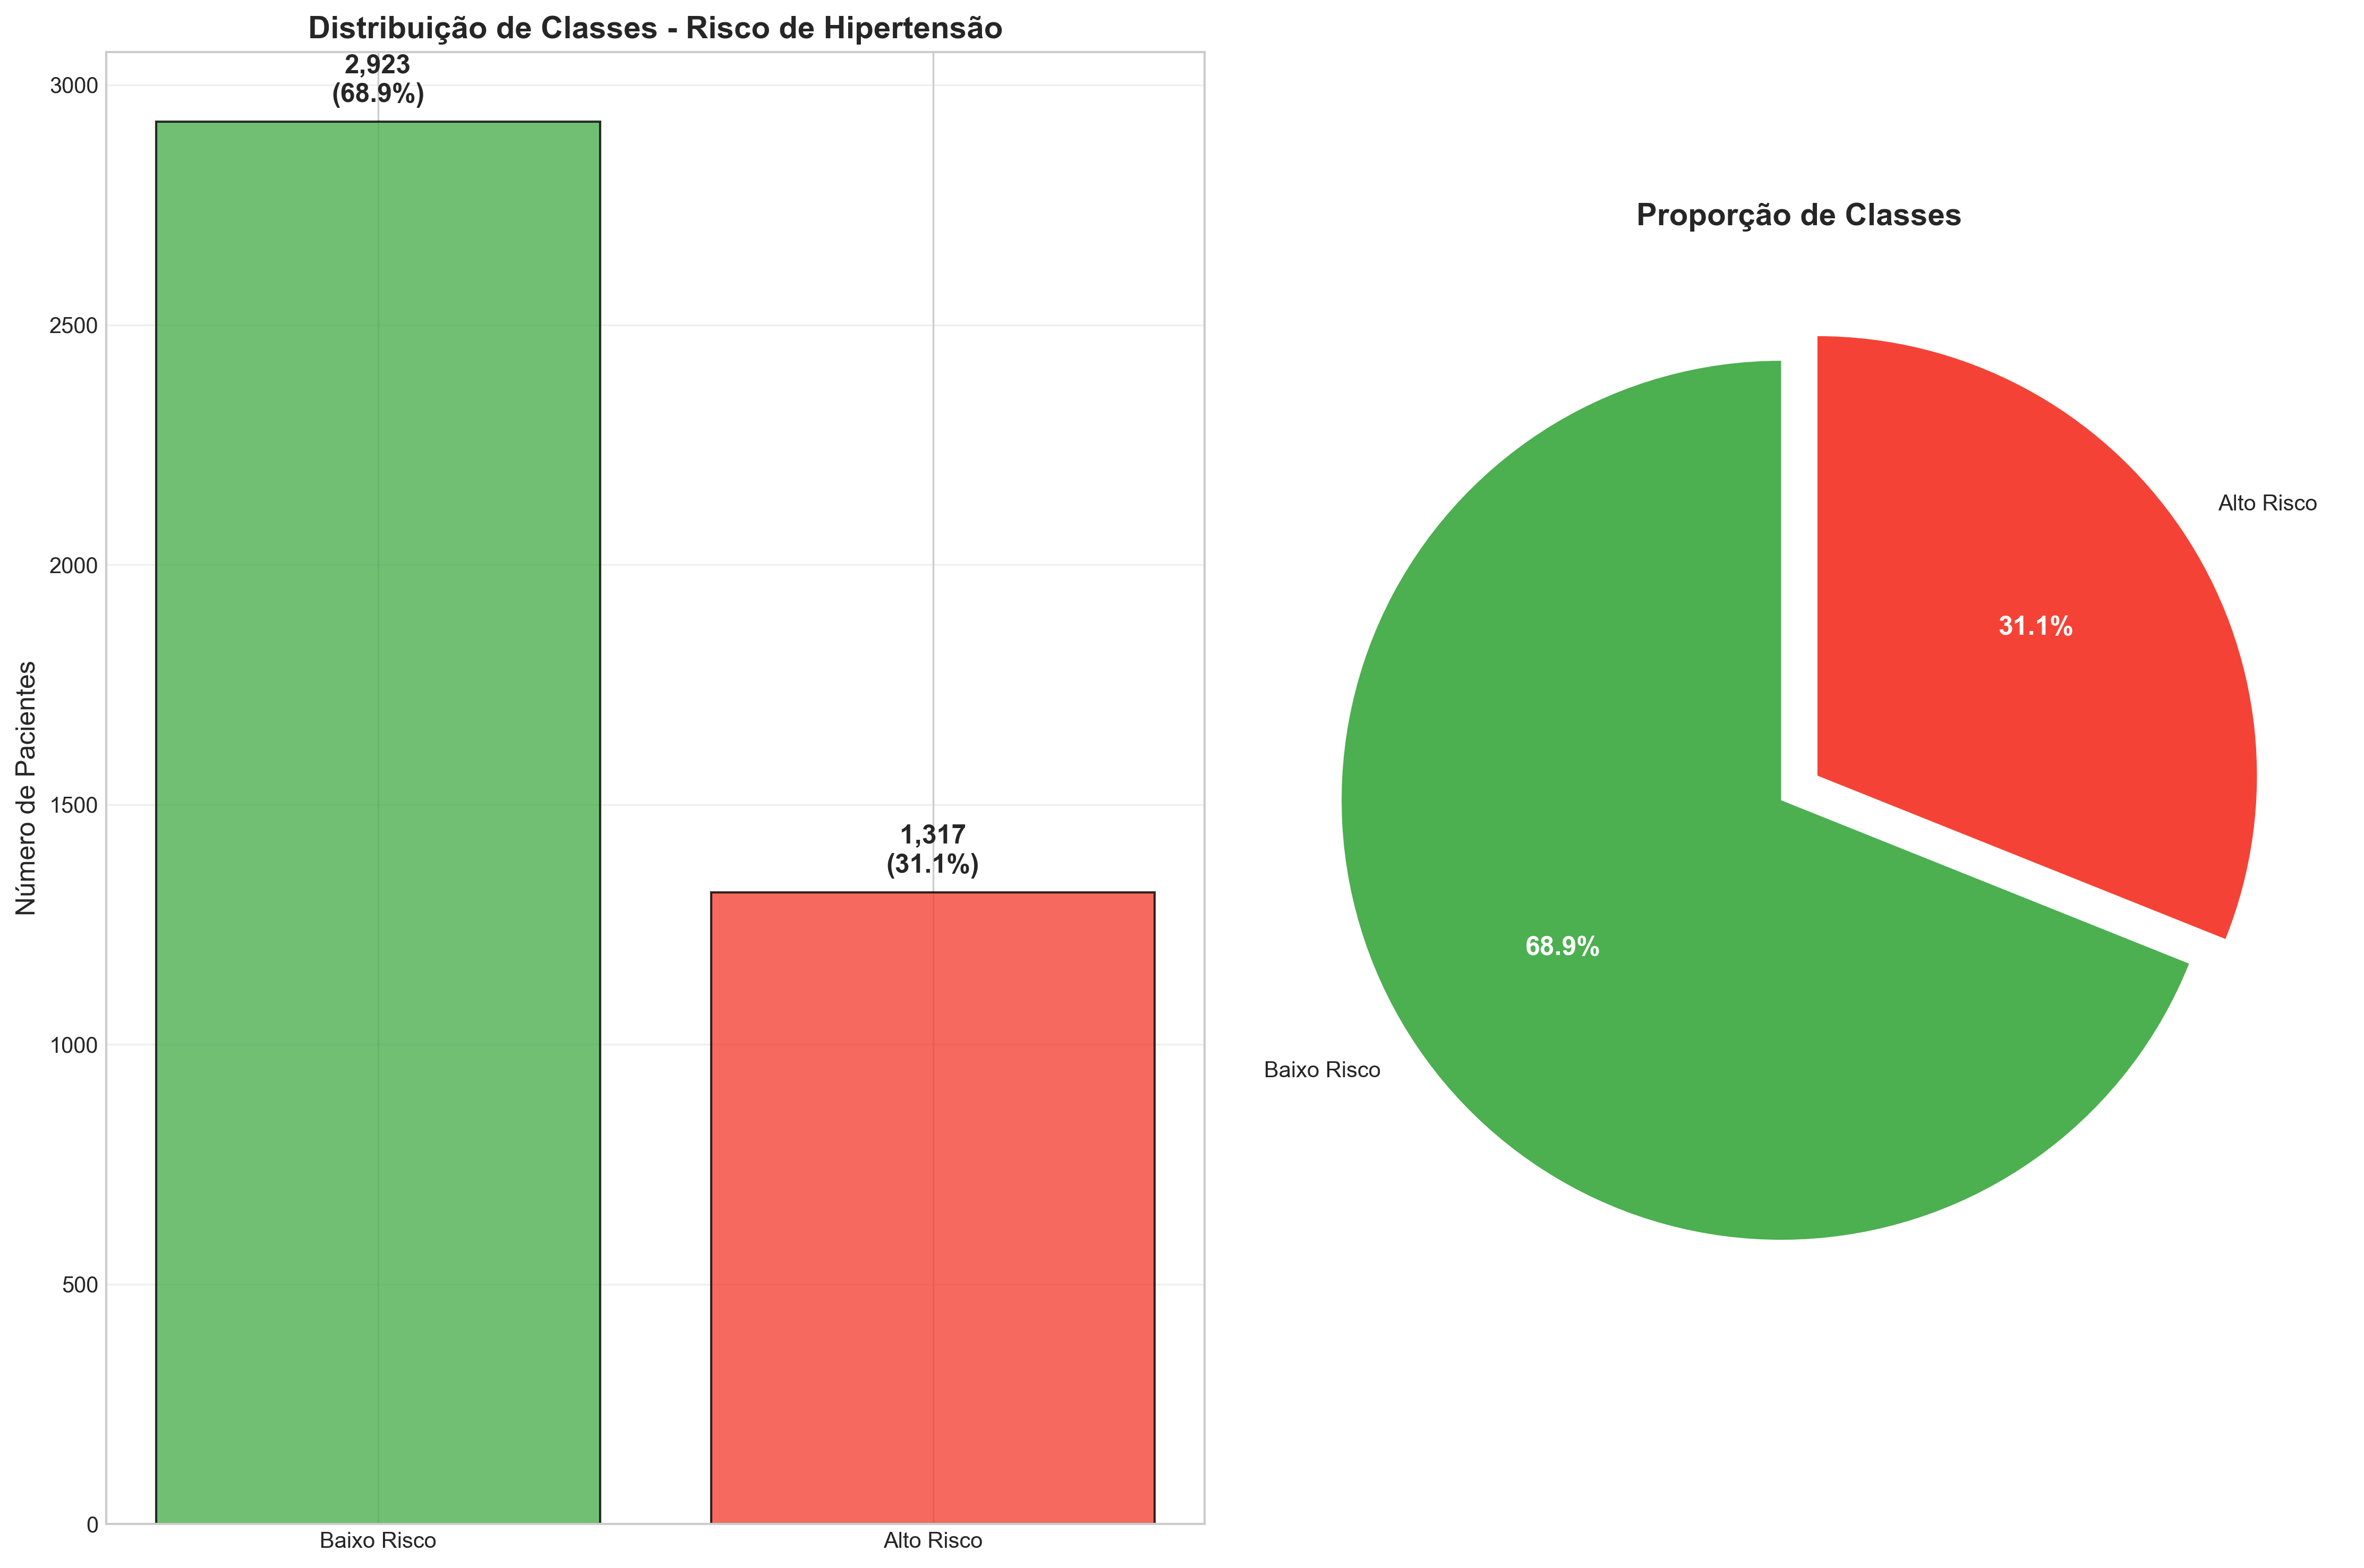

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

colors = ['#4CAF50', '#F44336']
labels = ['Baixo Risco', 'Alto Risco']

bars = ax1.bar(range(len(class_distribution)), class_distribution.values, 
               color=colors, alpha=0.8, edgecolor='black')

ax1.set_xticks(range(len(class_distribution)))
ax1.set_xticklabels(labels)
ax1.set_ylabel('Número de Pacientes')
ax1.set_title('Distribuição de Classes - Risco de Hipertensão', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for bar, count, pct in zip(bars, class_distribution.values, class_percentages.values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + max(class_distribution)*0.01,
             f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

wedges, texts, autotexts = ax2.pie(class_distribution.values, labels=labels, colors=colors,
                                   autopct='%1.1f%%', startangle=90, explode=(0.05, 0.05))

ax2.set_title('Proporção de Classes', fontweight='bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

plt.tight_layout()
save_figure(fig, 'target_distribution', 'eda')
plt.show()


## 6. Distribuições das Variáveis Numéricas

In [12]:
print_section("ANÁLISE DE DISTRIBUIÇÕES - VARIÁVEIS NUMÉRICAS")

if 'numeric_cols' not in globals():
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if 'target_col' not in globals():
    target_col = df.columns[-1]

numeric_features = [col for col in numeric_cols if col != target_col]

print(f"📊 Analisando {len(numeric_features)} variáveis numéricas")

if len(numeric_features) == 0:
    print("⚠️ Nenhuma variável numérica encontrada para análise")
else:
    CATEGORICAL_THRESHOLD = 10
    
    categorical_features = []
    continuous_features = []
    
    for col in numeric_features:
        n_unique = df[col].nunique()
        if n_unique <= CATEGORICAL_THRESHOLD:
            categorical_features.append(col)
        else:
            continuous_features.append(col)
    
    print(f"\n📦 Variáveis identificadas:")
    print(f"   🏷️  Categóricas ({len(categorical_features)}): {categorical_features}")
    print(f"   📈 Contínuas ({len(continuous_features)}): {continuous_features}")



 ANÁLISE DE DISTRIBUIÇÕES - VARIÁVEIS NUMÉRICAS
📊 Analisando 12 variáveis numéricas

📦 Variáveis identificadas:
   🏷️  Categóricas (4): ['sexo', 'fumante_atualmente', 'medicamento_pressao', 'diabetes']
   📈 Contínuas (8): ['idade', 'cigarros_por_dia', 'colesterol_total', 'pressao_sistolica', 'pressao_diastolica', 'imc', 'frequencia_cardiaca', 'glicose']



 DISTRIBUIÇÕES DAS VARIÁVEIS CONTÍNUAS (2X4)
🔄 VISUALIZAÇÃO RESTAURADA:
   • Gráficos 2x4 das variáveis contínuas
   • Histogramas com comparação por risco
   • Boxplots para identificar outliers
   • Estatísticas detalhadas
Figura salva em: C:\Users\Anderson\Downloads\tcc_hipertensao_arquivos\trabalho_tcc_mod_classifc_hipertensao-master\trabalho_tcc_mod_classifc_hipertensao-master\04_reports\figures\eda\continuous_distributions


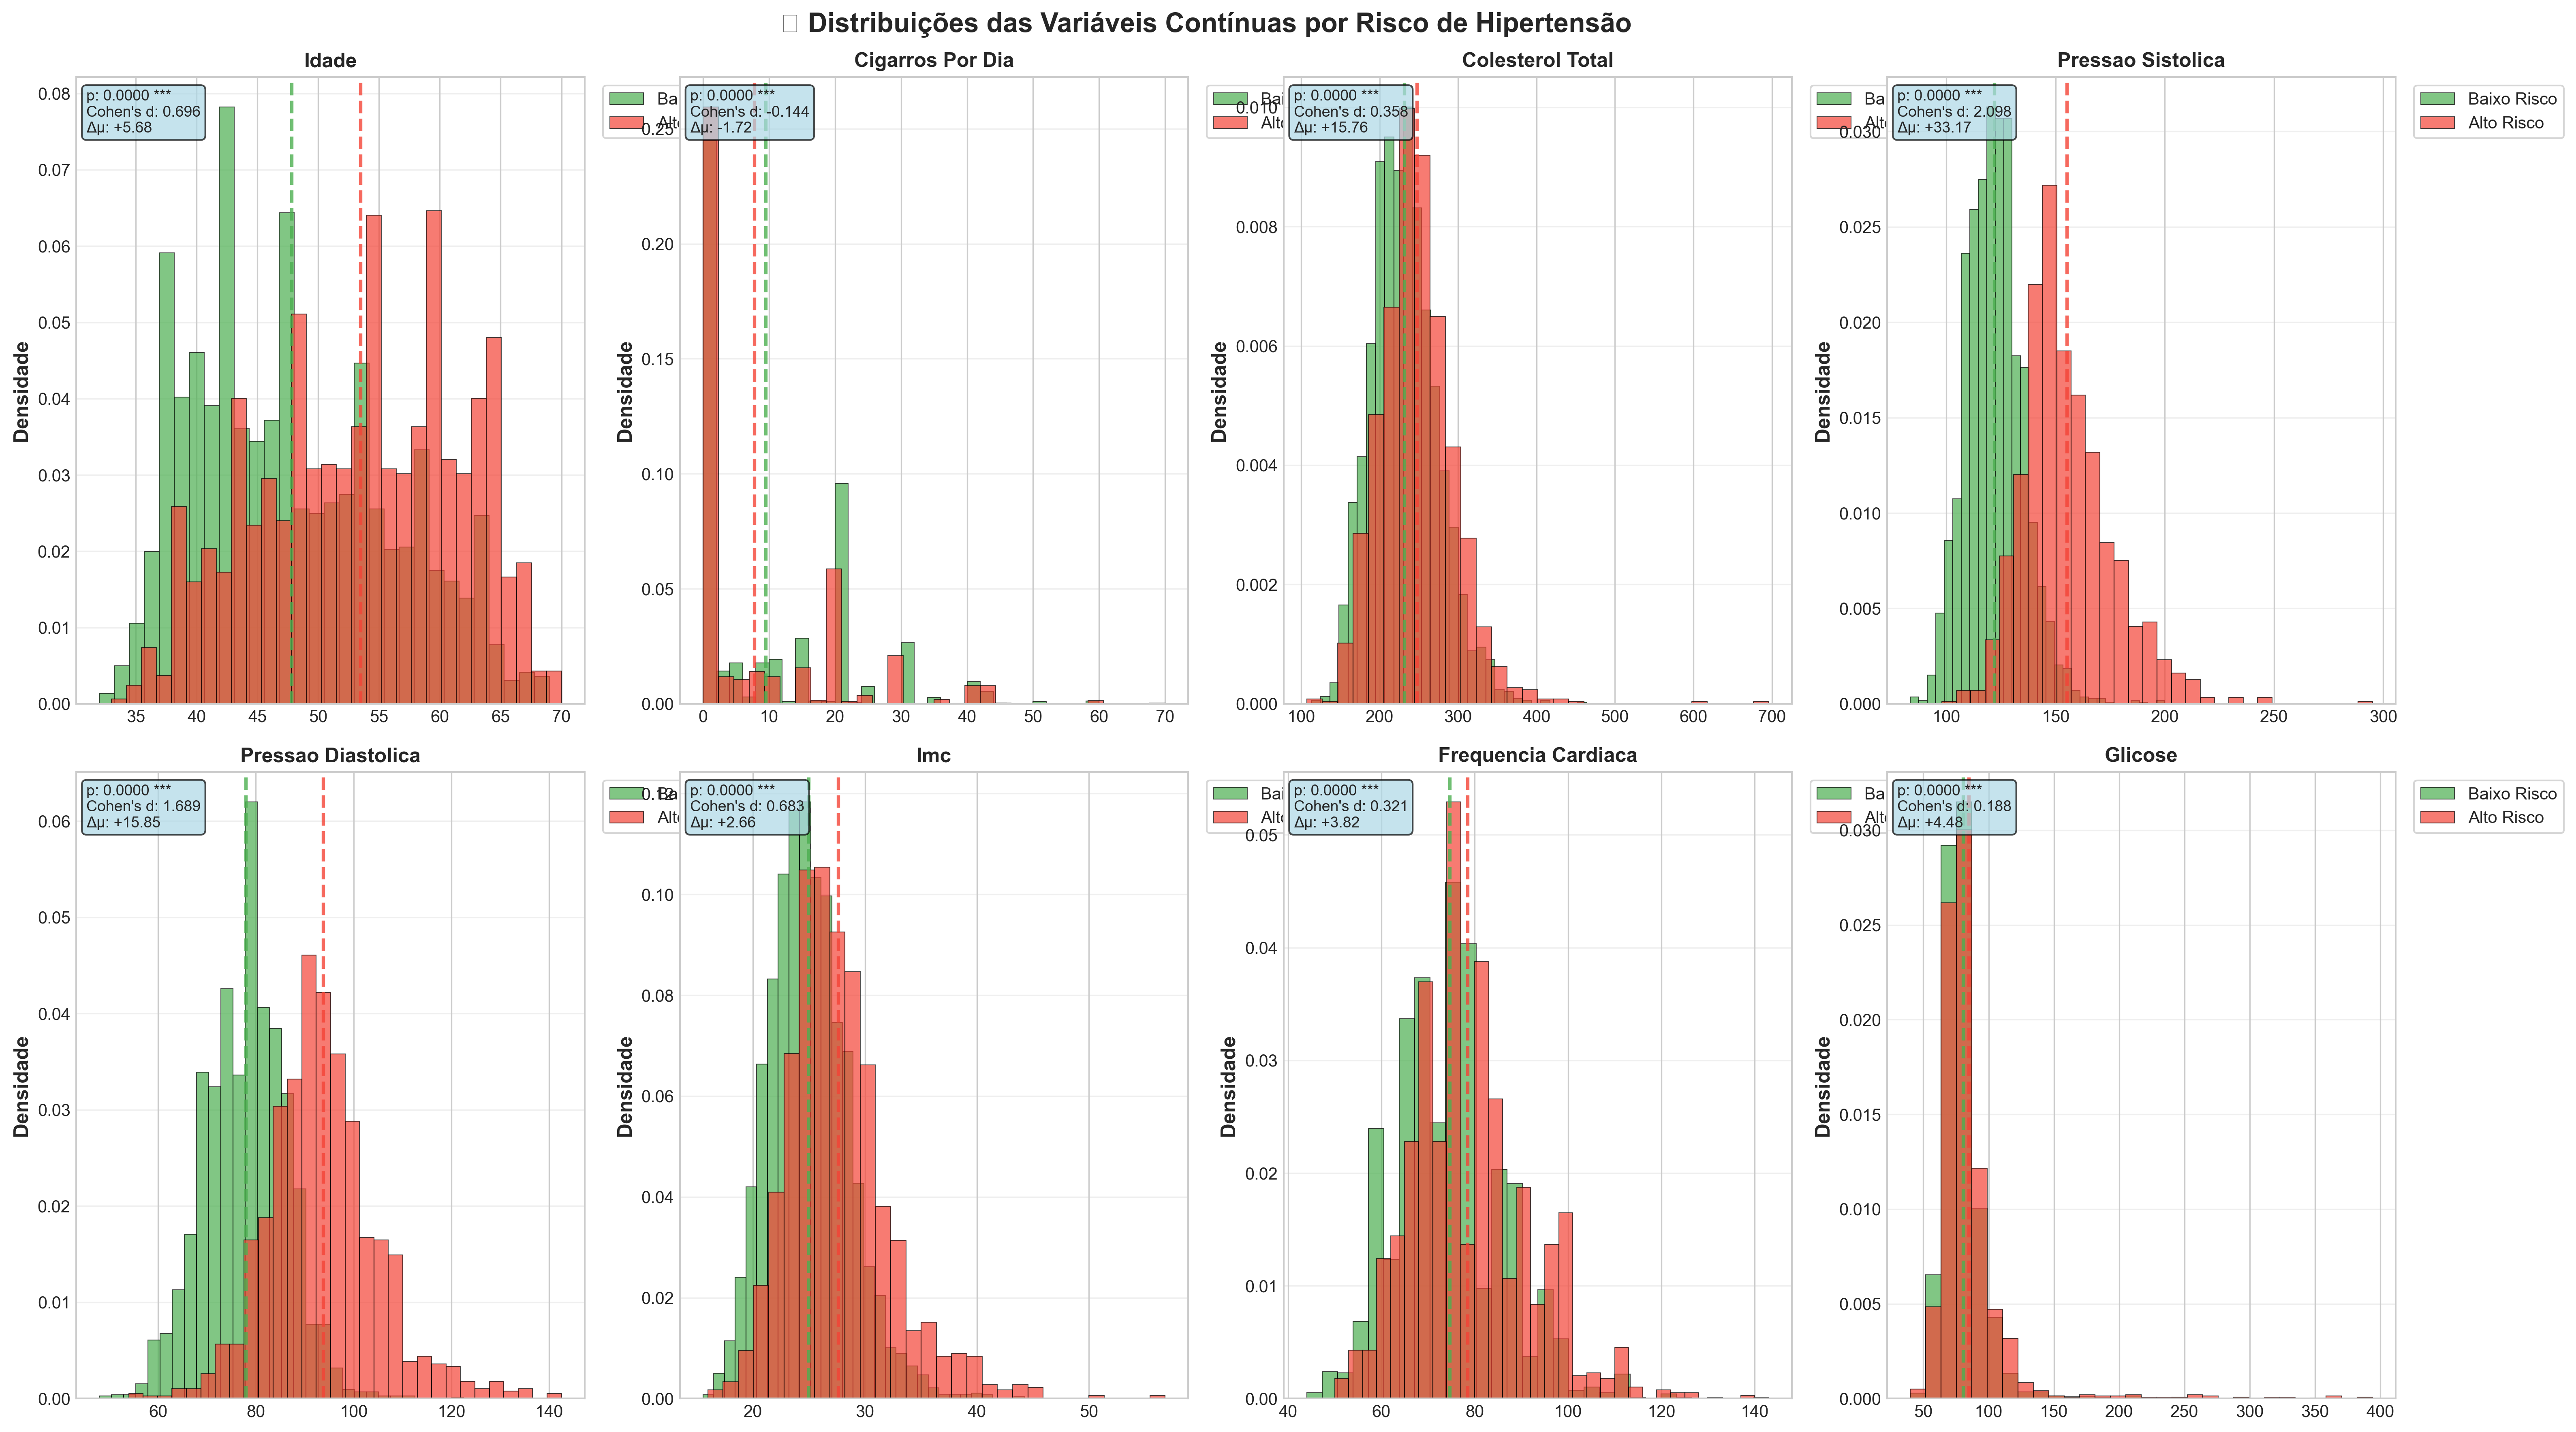


📊 ANÁLISE COMPLEMENTAR - BOXPLOTS:
Figura salva em: C:\Users\Anderson\Downloads\tcc_hipertensao_arquivos\trabalho_tcc_mod_classifc_hipertensao-master\trabalho_tcc_mod_classifc_hipertensao-master\04_reports\figures\eda\continuous_boxplots


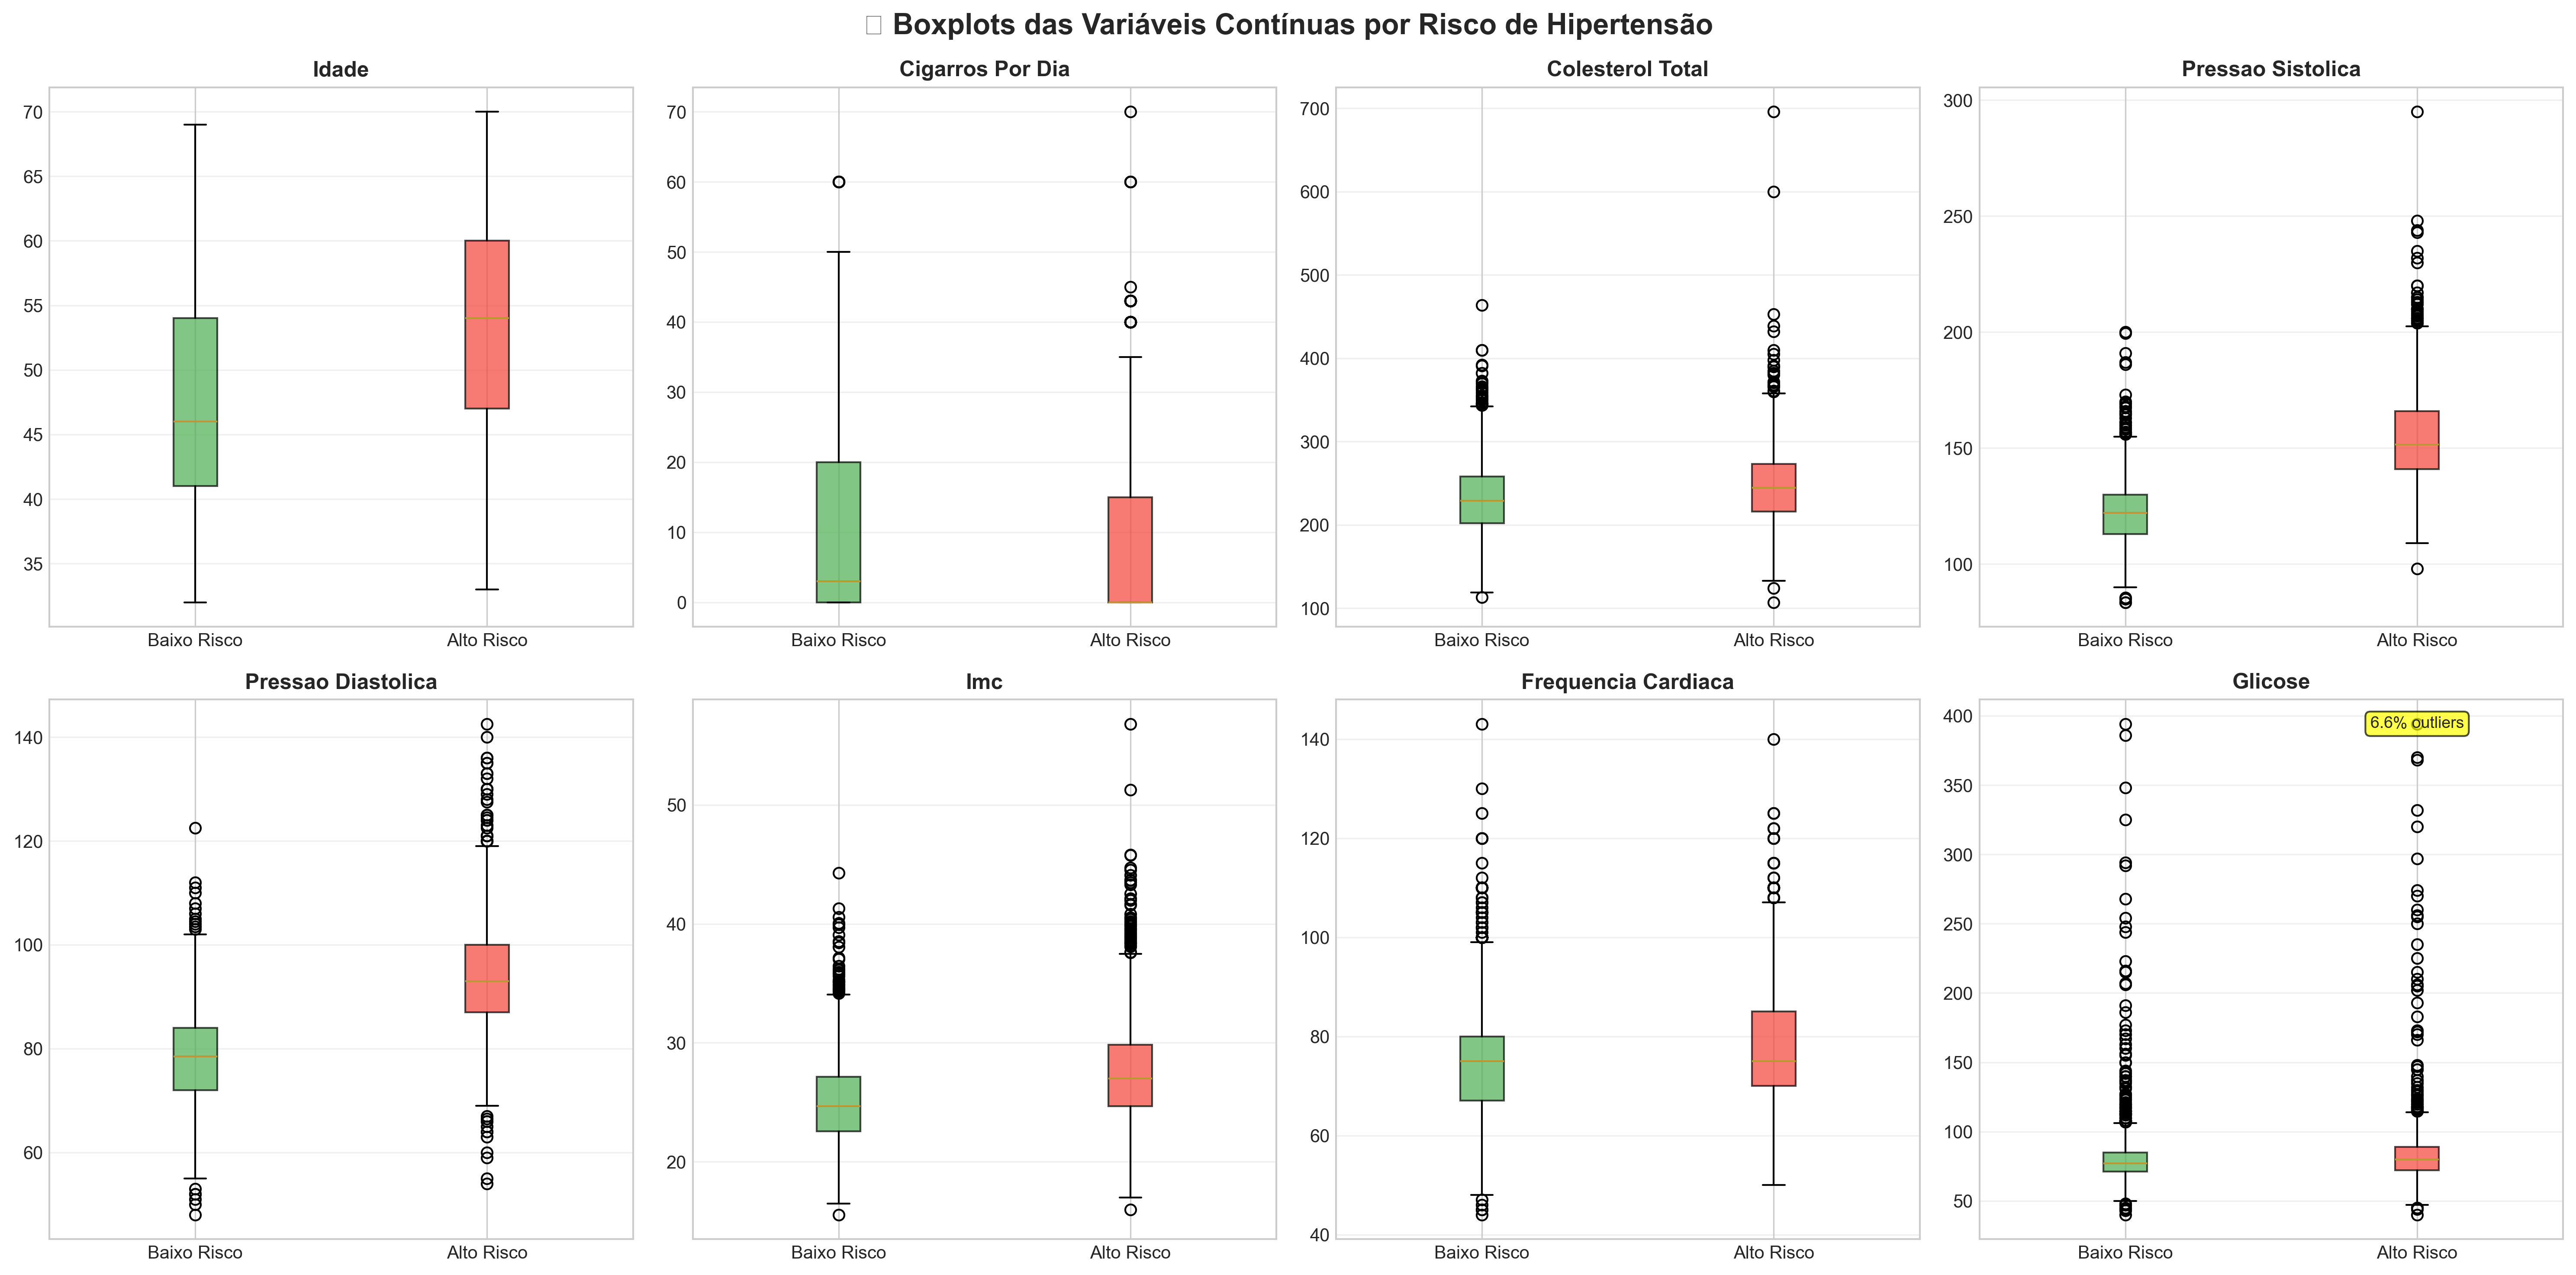


🔍 RESUMO ESTATÍSTICO DAS PRINCIPAIS DIFERENÇAS:
📊 Idade:
   • Grupo alto risco tem média 11.9% maior
   • Diferença absoluta: +5.68
   • p-value: 0.0000
📊 Cigarros Por Dia:
   • Grupo alto risco tem média 18.0% menor
   • Diferença absoluta: -1.72
   • p-value: 0.0000
📊 Colesterol Total:
   • Grupo alto risco tem média 6.8% maior
   • Diferença absoluta: +15.76
   • p-value: 0.0000
📊 Pressao Sistolica:
   • Grupo alto risco tem média 27.2% maior
   • Diferença absoluta: +33.17
   • p-value: 0.0000
📊 Pressao Diastolica:
   • Grupo alto risco tem média 20.3% maior
   • Diferença absoluta: +15.85
   • p-value: 0.0000
📊 Imc:
   • Grupo alto risco tem média 10.6% maior
   • Diferença absoluta: +2.66
   • p-value: 0.0000
📊 Frequencia Cardiaca:
   • Grupo alto risco tem média 5.1% maior
   • Diferença absoluta: +3.82
   • p-value: 0.0000
📊 Glicose:
   • Grupo alto risco tem média 5.6% maior
   • Diferença absoluta: +4.48
   • p-value: 0.0000

✅ 8 variáveis com diferenças estatisticamente sig

In [13]:
# 📈 CORREÇÃO: Visualização 2x4 das Distribuições Contínuas (RESTAURADA)
print_section("DISTRIBUIÇÕES DAS VARIÁVEIS CONTÍNUAS (2x4)")

print("🔄 VISUALIZAÇÃO RESTAURADA:")
print("   • Gráficos 2x4 das variáveis contínuas")
print("   • Histogramas com comparação por risco")
print("   • Boxplots para identificar outliers")
print("   • Estatísticas detalhadas")

if len(continuous_features) >= 8:
    # Criar figura com subplots 2x4
    fig, axes = plt.subplots(2, 4, figsize=(20, 12))
    fig.suptitle('📈 Distribuições das Variáveis Contínuas por Risco de Hipertensão', 
                fontsize=16, fontweight='bold', y=0.98)
    
    colors = ['#4CAF50', '#F44336']  # Verde para baixo risco, vermelho para alto risco
    
    for i, var in enumerate(continuous_features[:8]):
        row, col = divmod(i, 4)
        ax = axes[row, col]
        
        # Separar dados por grupo de risco
        data_baixo_risco = df[df[target_col] == 0][var].dropna()
        data_alto_risco = df[df[target_col] == 1][var].dropna()
        
        # Histograma sobreposto
        ax.hist(data_baixo_risco, bins=30, alpha=0.7, color=colors[0], 
               label='Baixo Risco', density=True, edgecolor='black', linewidth=0.5)
        ax.hist(data_alto_risco, bins=30, alpha=0.7, color=colors[1], 
               label='Alto Risco', density=True, edgecolor='black', linewidth=0.5)
        
        # Formatação
        ax.set_title(f'{var.replace("_", " ").title()}', fontweight='bold', fontsize=12)
        ax.set_xlabel('')
        ax.set_ylabel('Densidade', fontweight='bold')
        ax.legend(loc='upper right')
        ax.grid(axis='y', alpha=0.3)
        
        # Adicionar linhas das médias
        mean_baixo = data_baixo_risco.mean()
        mean_alto = data_alto_risco.mean()
        
        ax.axvline(mean_baixo, color=colors[0], linestyle='--', linewidth=2, alpha=0.8)
        ax.axvline(mean_alto, color=colors[1], linestyle='--', linewidth=2, alpha=0.8)
        
        # Teste estatístico (Mann-Whitney U)
        if len(data_baixo_risco) > 1 and len(data_alto_risco) > 1:
            stat, p_value = mannwhitneyu(data_baixo_risco, data_alto_risco, alternative='two-sided')
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
            
            # Cohen's d (effect size)
            pooled_std = np.sqrt(((len(data_baixo_risco) - 1) * data_baixo_risco.var() + 
                                (len(data_alto_risco) - 1) * data_alto_risco.var()) / 
                               (len(data_baixo_risco) + len(data_alto_risco) - 2))
            cohens_d = (mean_alto - mean_baixo) / pooled_std if pooled_std > 0 else 0
            
            ax.text(0.02, 0.98, 
                   f'p: {p_value:.4f} {significance}\nCohen\'s d: {cohens_d:.3f}\nΔμ: {mean_alto-mean_baixo:+.2f}', 
                   transform=ax.transAxes, fontsize=9, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    plt.tight_layout()
    save_figure(fig, 'continuous_distributions', 'eda')
    plt.show()
    
    # Análise complementar com boxplots
    print(f"\n📊 ANÁLISE COMPLEMENTAR - BOXPLOTS:")
    
    fig2, axes2 = plt.subplots(2, 4, figsize=(20, 10))
    fig2.suptitle('📦 Boxplots das Variáveis Contínuas por Risco de Hipertensão', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    for i, var in enumerate(continuous_features[:8]):
        row, col = divmod(i, 4)
        ax = axes2[row, col]
        
        # Preparar dados para boxplot
        data_plot = []
        labels_plot = []
        
        for risk_level, risk_label in [(0, 'Baixo Risco'), (1, 'Alto Risco')]:
            var_data = df[df[target_col] == risk_level][var].dropna()
            if len(var_data) > 0:
                data_plot.append(var_data)
                labels_plot.append(risk_label)
        
        # Boxplot
        bp = ax.boxplot(data_plot, labels=labels_plot, patch_artist=True)
        
        # Colorir boxplots
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        # Formatação
        ax.set_title(f'{var.replace("_", " ").title()}', fontweight='bold', fontsize=12)
        ax.grid(axis='y', alpha=0.3)
        
        # Identificar outliers percentualmente
        for j, data in enumerate(data_plot):
            Q1, Q3 = data.quantile([0.25, 0.75])
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers_count = ((data < lower_bound) | (data > upper_bound)).sum()
            outliers_pct = (outliers_count / len(data)) * 100
            
            if outliers_pct > 5:  # Se mais de 5% são outliers
                ax.text(j+1, ax.get_ylim()[1] * 0.95, f'{outliers_pct:.1f}% outliers', 
                       ha='center', fontsize=9, 
                       bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    plt.tight_layout()
    save_figure(fig2, 'continuous_boxplots', 'eda')
    plt.show()
    
    # Resumo estatístico
    print(f"\n🔍 RESUMO ESTATÍSTICO DAS PRINCIPAIS DIFERENÇAS:")
    print("="*80)
    
    significant_vars = []
    
    for var in continuous_features[:8]:
        data_baixo = df[df[target_col] == 0][var].dropna()
        data_alto = df[df[target_col] == 1][var].dropna()
        
        if len(data_baixo) > 1 and len(data_alto) > 1:
            stat, p_value = mannwhitneyu(data_baixo, data_alto, alternative='two-sided')
            
            if p_value < 0.05:
                mean_diff = data_alto.mean() - data_baixo.mean()
                pct_diff = (mean_diff / abs(data_baixo.mean())) * 100 if data_baixo.mean() != 0 else 0
                
                direction = "maior" if mean_diff > 0 else "menor"
                
                print(f"📊 {var.replace('_', ' ').title()}:")
                print(f"   • Grupo alto risco tem média {abs(pct_diff):.1f}% {direction}")
                print(f"   • Diferença absoluta: {mean_diff:+.2f}")
                print(f"   • p-value: {p_value:.4f}")
                
                significant_vars.append(var)
    
    print(f"\n✅ {len(significant_vars)} variáveis com diferenças estatisticamente significativas")
    
else:
    print("⚠️ Insuficientes variáveis contínuas para análise 2x4")

print(f"\n✅ Visualização contínua 2x4 restaurada com sucesso!")



 DISTRIBUIÇÕES DAS VARIÁVEIS CATEGÓRICAS (2X2)
🔄 VISUALIZAÇÃO RESTAURADA:
   • Gráficos 2x2 das variáveis categóricas
   • Comparação por grupo de risco
   • Legendas e cores distintivas
Figura salva em: C:\Users\Anderson\Downloads\tcc_hipertensao_arquivos\trabalho_tcc_mod_classifc_hipertensao-master\trabalho_tcc_mod_classifc_hipertensao-master\04_reports\figures\eda\categorical_distributions


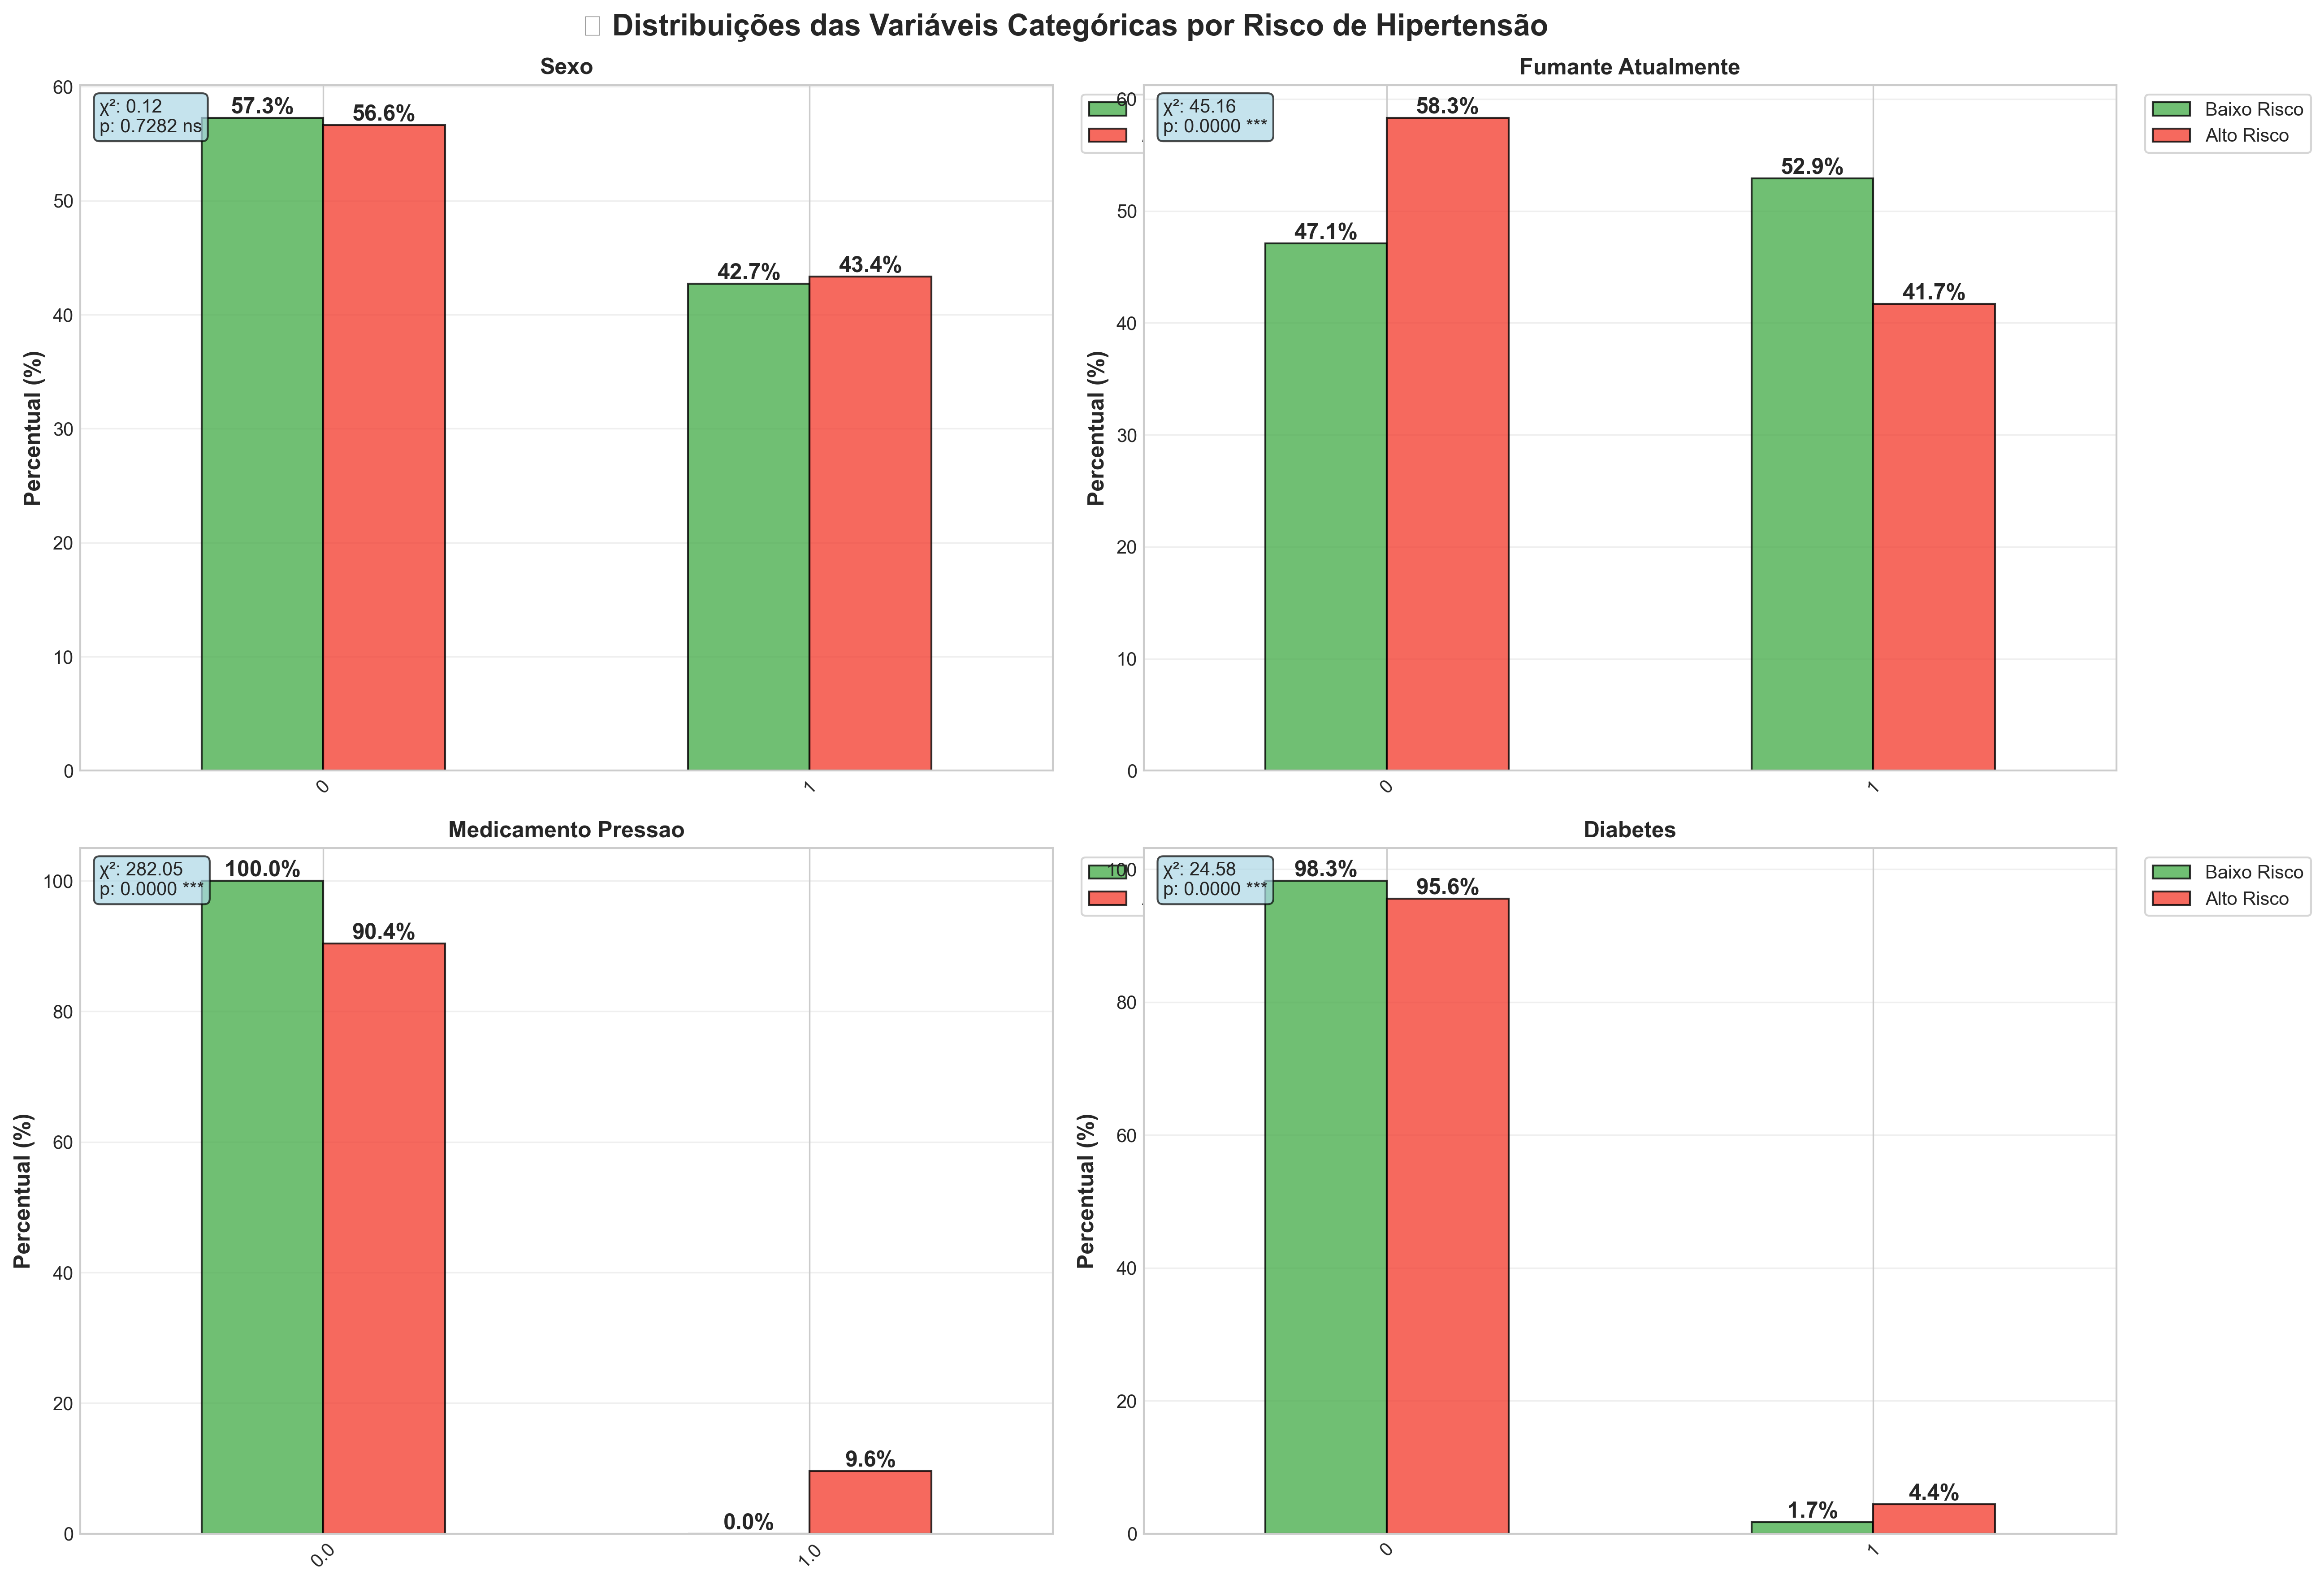


🔍 ANÁLISE INTERPRETATIVA:

📊 Sexo:
   • Diferença de risco pequena: 0.5%

📊 Fumante Atualmente:
   • Categoria 1 tem 9.6% menor risco que categoria 0

📊 Medicamento Pressao:
   • Categoria 1 tem 71.2% maior risco que categoria 0

📊 Diabetes:
   • Categoria 1 tem 22.7% maior risco que categoria 0

✅ Visualização categórica 2x2 restaurada com sucesso!


In [14]:
# 📊 CORREÇÃO: Visualização 2x2 das Distribuições Categóricas (RESTAURADA)
print_section("DISTRIBUIÇÕES DAS VARIÁVEIS CATEGÓRICAS (2x2)")

print("🔄 VISUALIZAÇÃO RESTAURADA:")
print("   • Gráficos 2x2 das variáveis categóricas")
print("   • Comparação por grupo de risco")
print("   • Legendas e cores distintivas")

if len(categorical_features) >= 4:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('📦 Distribuições das Variáveis Categóricas por Risco de Hipertensão', 
                fontsize=16, fontweight='bold', y=0.98)
    
    colors = ['#4CAF50', '#F44336']  # Verde para baixo risco, vermelho para alto risco
    labels = ['Baixo Risco', 'Alto Risco']
    
    for i, var in enumerate(categorical_features[:4]):
        row, col = divmod(i, 2)
        ax = axes[row, col]
        
        # Criar crosstab para análise
        crosstab = pd.crosstab(df[var], df[target_col], normalize='columns') * 100
        
        # Gráfico de barras agrupadas
        crosstab.plot(kind='bar', ax=ax, color=colors, alpha=0.8, 
                     edgecolor='black', linewidth=1)
        
        # Formatação
        ax.set_title(f'{var.replace("_", " ").title()}', fontweight='bold', fontsize=12)
        ax.set_xlabel('')
        ax.set_ylabel('Percentual (%)', fontweight='bold')
        ax.legend(labels, loc='upper right')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3)
        
        # Adicionar valores nas barras
        for container in ax.containers:
            ax.bar_label(container, fmt='%.1f%%', fontweight='bold')
        
        # Análise estatística básica
        chi2, p_value = chi2_contingency(pd.crosstab(df[var], df[target_col]))[:2]
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        
        ax.text(0.02, 0.98, f'χ²: {chi2:.2f}\np: {p_value:.4f} {significance}', 
               transform=ax.transAxes, fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    plt.tight_layout()
    save_figure(fig, 'categorical_distributions', 'eda')
    plt.show()
    
    # Análise interpretativa
    print(f"\n🔍 ANÁLISE INTERPRETATIVA:")
    print("="*80)
    
    for var in categorical_features[:4]:
        crosstab_counts = pd.crosstab(df[var], df[target_col])
        crosstab_pct = pd.crosstab(df[var], df[target_col], normalize='index') * 100
        
        print(f"\n📊 {var.replace('_', ' ').title()}:")
        
        # Identificar categoria de maior risco
        if crosstab_pct.shape[0] == 2:  # Variável binária
            risk_diff = crosstab_pct.loc[1, 1] - crosstab_pct.loc[0, 1] if 1 in crosstab_pct.index else 0
            
            if abs(risk_diff) > 5:  # Diferença > 5% é relevante
                direction = "maior" if risk_diff > 0 else "menor"
                print(f"   • Categoria 1 tem {abs(risk_diff):.1f}% {direction} risco que categoria 0")
            else:
                print(f"   • Diferença de risco pequena: {risk_diff:.1f}%")
    
else:
    print("⚠️ Insuficientes variáveis categóricas para análise 2x2")

print(f"\n✅ Visualização categórica 2x2 restaurada com sucesso!")


## 7. Análise de Outliers

## 8. Análise de Correlações


 ANÁLISE DE CORRELAÇÕES
Figura salva em: C:\Users\Anderson\Downloads\tcc_hipertensao_arquivos\trabalho_tcc_mod_classifc_hipertensao-master\trabalho_tcc_mod_classifc_hipertensao-master\04_reports\figures\eda\correlation_matrix


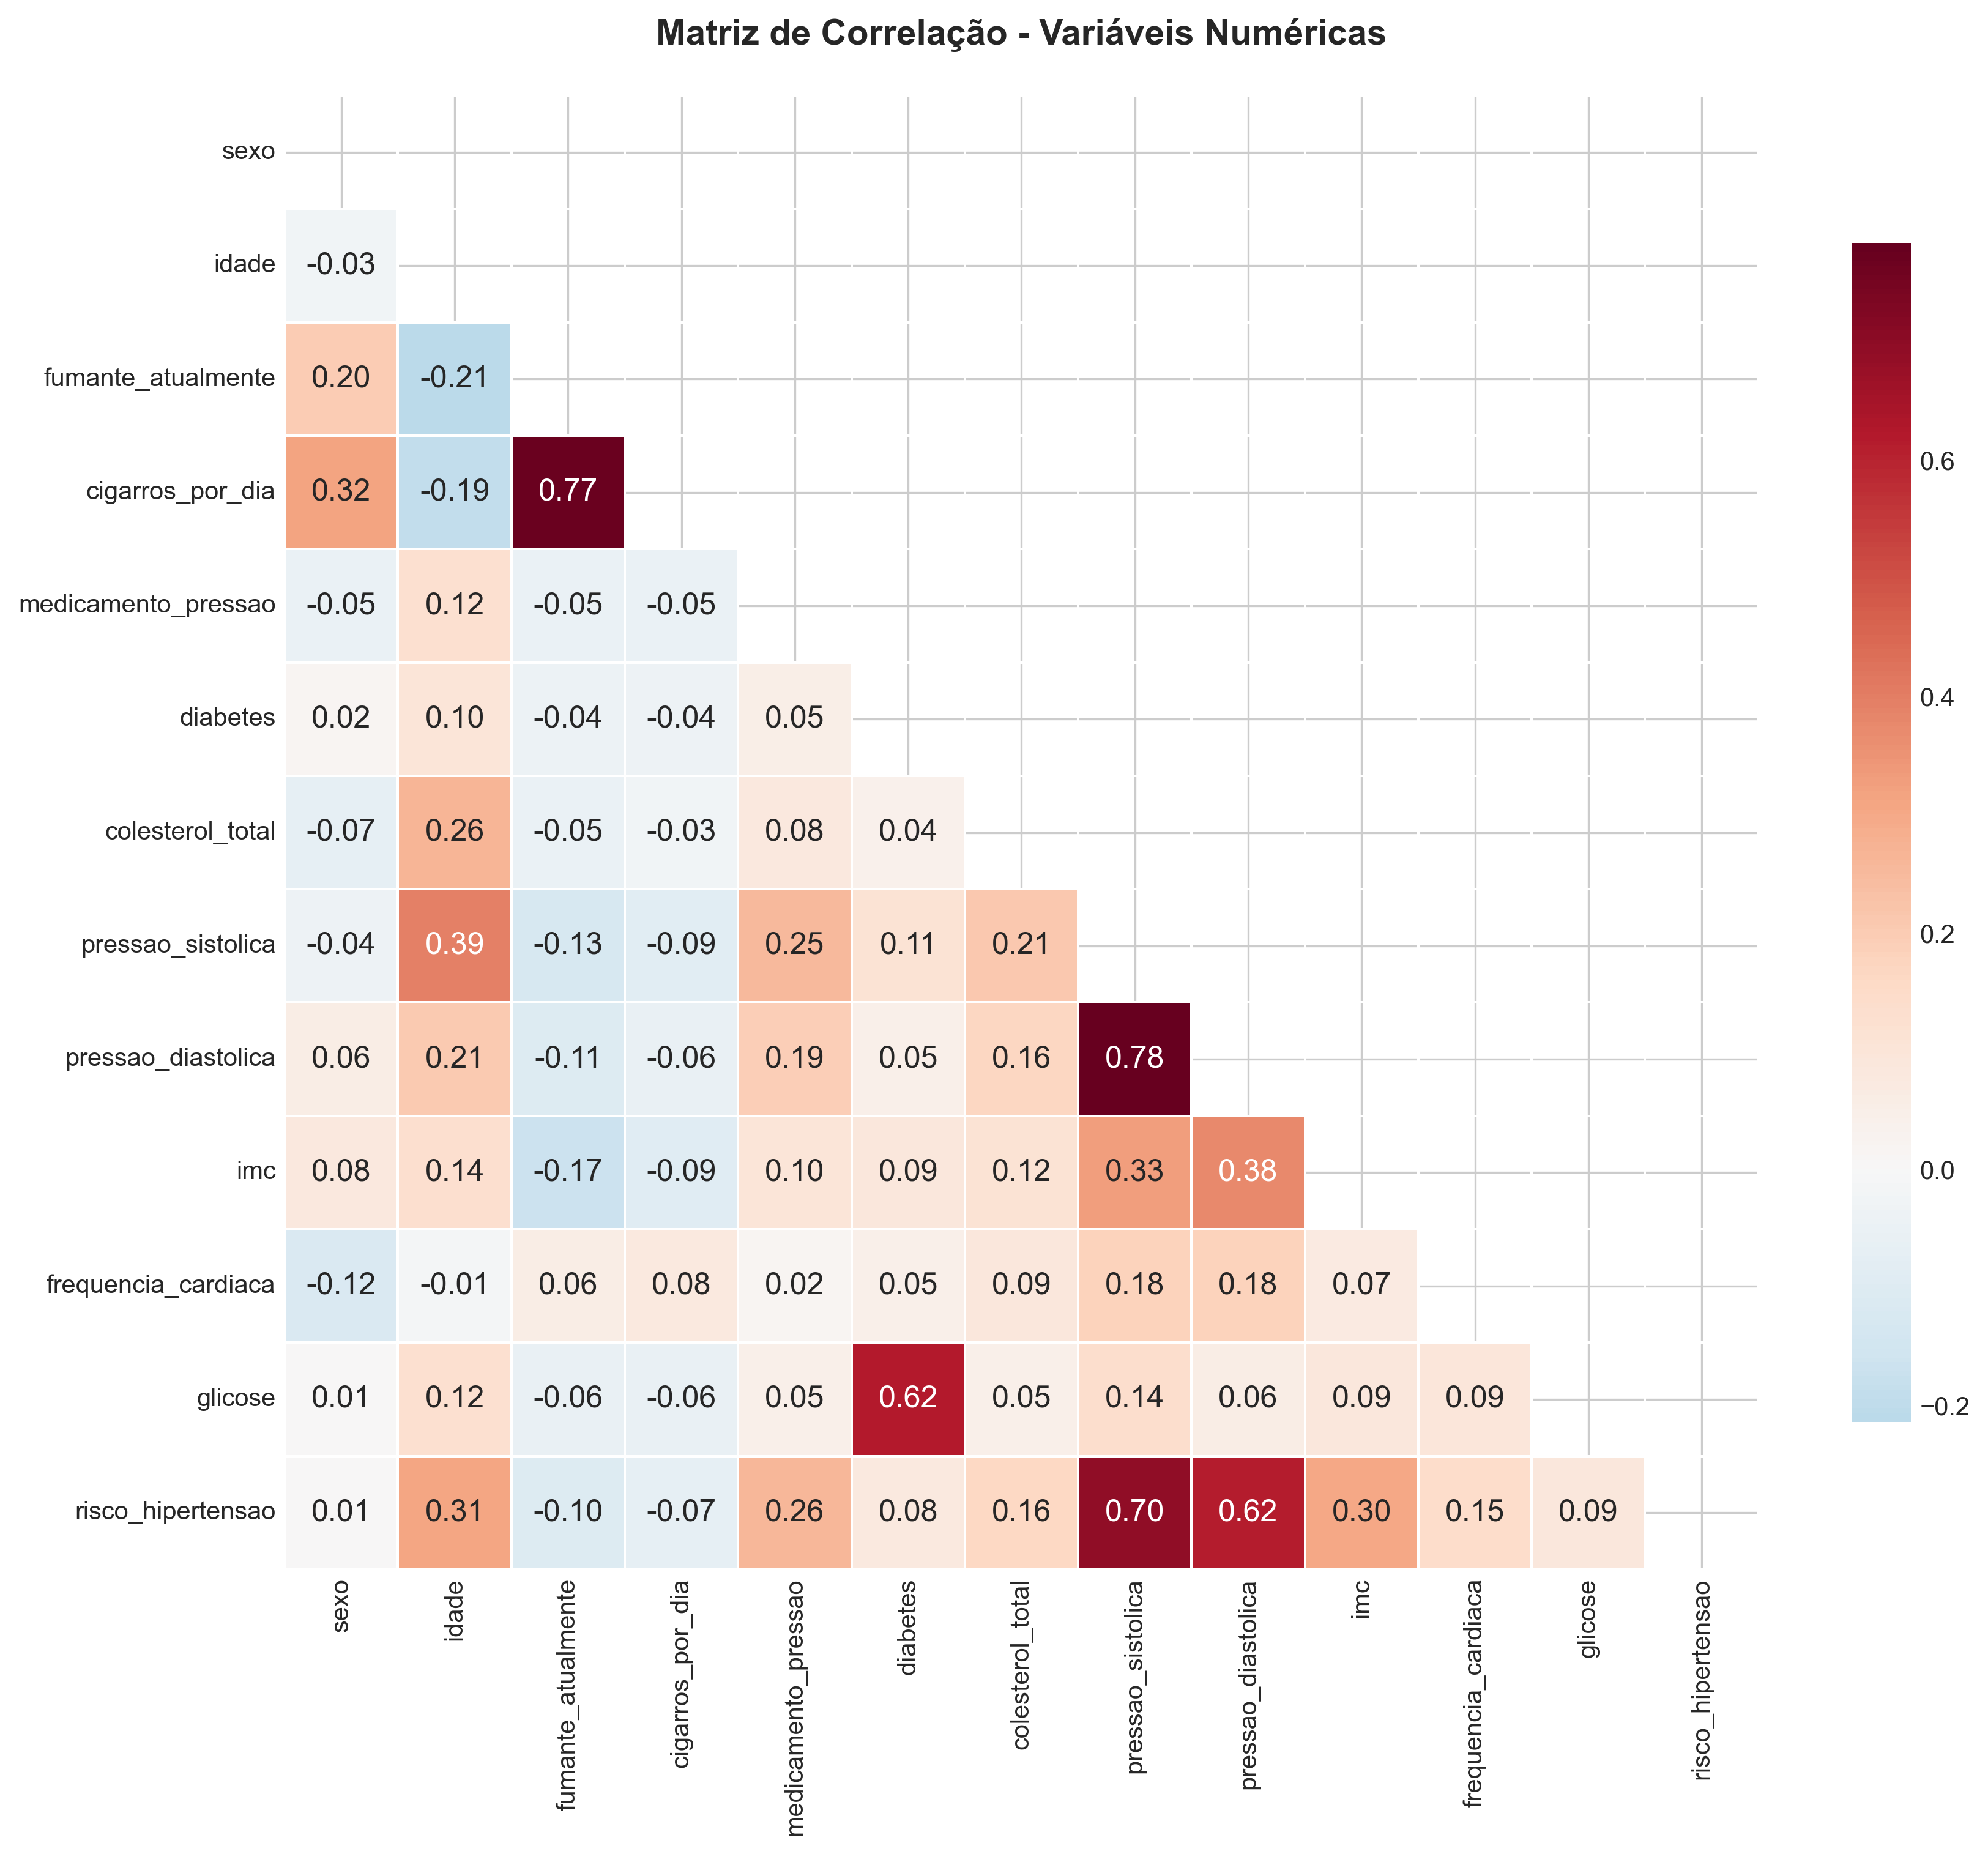


🎯 Correlações com 'risco_hipertensao':
  📈 pressao_sistolica: 0.697 (forte)
  📈 pressao_diastolica: 0.616 (forte)
  📈 idade: 0.307 (moderada)
  📈 imc: 0.301 (moderada)
  📈 medicamento_pressao: 0.261 (fraca)
  📈 colesterol_total: 0.164 (fraca)
  📈 frequencia_cardiaca: 0.147 (fraca)
  📉 fumante_atualmente: -0.104 (fraca)
  📈 glicose: 0.087 (fraca)
  📈 diabetes: 0.078 (fraca)
  📉 cigarros_por_dia: -0.067 (fraca)
  📈 sexo: 0.006 (fraca)


In [15]:
print_section("ANÁLISE DE CORRELAÇÕES")

if 'numeric_cols' not in globals():
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if 'target_col' not in globals():
    target_col = df.columns[-1]

if len(numeric_cols) < 2:
    print("⚠️ Insuficientes variáveis numéricas para análise de correlação")
else:
    correlation_matrix = df[numeric_cols].corr()
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    heatmap = sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                          square=True, linewidths=0.5, cbar_kws={"shrink": .8}, 
                          fmt='.2f', ax=ax)
    
    ax.set_title('Matriz de Correlação - Variáveis Numéricas', fontweight='bold', pad=20)
    plt.tight_layout()
    save_figure(fig, 'correlation_matrix', 'eda')
    plt.show()
    
    if target_col in correlation_matrix.columns:
        target_correlations = correlation_matrix[target_col].drop(target_col).sort_values(key=abs, ascending=False)
        
        print(f"\n🎯 Correlações com '{target_col}':")
        for var, corr in target_correlations.items():
            direction = "📈" if corr > 0 else "📉"
            strength = "forte" if abs(corr) > 0.5 else "moderada" if abs(corr) > 0.3 else "fraca"
            print(f"  {direction} {var}: {corr:.3f} ({strength})")


## 9. Análise Estatística Comparativa Aprofundada

Esta seção implementa testes estatísticos rigorosos para validar diferenças entre grupos:
- **Mann-Whitney U Test**: Para variáveis contínuas (não paramétrico)
- **Cohen's d**: Para medir o tamanho do efeito (effect size)
- **Interpretação de significância**: p-values e classificação de efeitos

In [16]:
print_section("ANÁLISE ESTATÍSTICA COMPARATIVA COMPLETA")

def analise_estatistica_completa(df, target_col='risco_hipertensao'):
    """
    Realiza análise estatística comparando grupos com/sem hipertensão
    
    Testes aplicados:
    - Mann-Whitney U: teste não-paramétrico para diferenças entre grupos
    - Cohen's d: medida de tamanho do efeito
    """
    resultados = []
    
    # Separar grupos
    grupo_0 = df[df[target_col] == 0]
    grupo_1 = df[df[target_col] == 1]
    
    # Variáveis numéricas
    vars_numericas = df.select_dtypes(include=[np.number]).columns
    vars_numericas = [v for v in vars_numericas if v != target_col]
    
    print("="*80)
    print("ANÁLISE ESTATÍSTICA COMPARATIVA")
    print("="*80)
    print(f"\n📊 Comparando {len(grupo_0):,} pacientes sem risco vs {len(grupo_1):,} com risco")
    print(f"🔬 Analisando {len(vars_numericas)} variáveis numéricas\n")
    
    for var in vars_numericas:
        try:
            # Remover valores ausentes
            data_0 = grupo_0[var].dropna()
            data_1 = grupo_1[var].dropna()
            
            if len(data_0) < 2 or len(data_1) < 2:
                continue
            
            # Mann-Whitney U test
            stat, p_value = mannwhitneyu(
                data_0,
                data_1,
                alternative='two-sided'
            )
            
            # Cohen's d (effect size)
            mean_0 = data_0.mean()
            mean_1 = data_1.mean()
            std_0 = data_0.std()
            std_1 = data_1.std()
            
            # Pooled standard deviation
            n_0 = len(data_0)
            n_1 = len(data_1)
            std_pooled = np.sqrt(((n_0 - 1) * std_0**2 + (n_1 - 1) * std_1**2) / (n_0 + n_1 - 2))
            
            cohens_d = (mean_1 - mean_0) / std_pooled if std_pooled > 0 else 0
            
            # Classificar effect size
            if abs(cohens_d) < 0.2:
                effect_size_label = 'Desprezível'
            elif abs(cohens_d) < 0.5:
                effect_size_label = 'Pequeno'
            elif abs(cohens_d) < 0.8:
                effect_size_label = 'Médio'
            else:
                effect_size_label = 'Grande'
            
            resultados.append({
                'variavel': var,
                'media_sem_risco': mean_0,
                'desvio_sem_risco': std_0,
                'media_com_risco': mean_1,
                'desvio_com_risco': std_1,
                'diferenca_media': mean_1 - mean_0,
                'diferenca_percentual': ((mean_1 - mean_0) / abs(mean_0) * 100) if mean_0 != 0 else 0,
                'p_value': p_value,
                'significativo': 'Sim' if p_value < 0.05 else 'Não',
                'cohens_d': cohens_d,
                'effect_size': effect_size_label,
                'n_sem_risco': n_0,
                'n_com_risco': n_1
            })
            
        except Exception as e:
            print(f"⚠️ Erro ao analisar {var}: {e}")
            continue
    
    df_resultados = pd.DataFrame(resultados)
    df_resultados = df_resultados.sort_values('p_value')
    
    return df_resultados

# Executar análise
df_stats = analise_estatistica_completa(df, target_col)

if len(df_stats) > 0:
    print("\n📋 RESULTADOS DOS TESTES ESTATÍSTICOS:")
    print("="*80)
    
    # Formatar e exibir resultados
    df_stats_display = df_stats[['variavel', 'media_sem_risco', 'media_com_risco', 
                                  'diferenca_percentual', 'p_value', 'significativo', 
                                  'cohens_d', 'effect_size']].copy()
    
    df_stats_display.columns = ['Variável', 'Média Baixo Risco', 'Média Alto Risco', 
                                 'Dif. %', 'p-value', 'Signif.', "Cohen's d", 'Effect Size']
    
    display(df_stats_display.round(4))
    
    # Resumo de variáveis significativas
    vars_significativas = df_stats[df_stats['significativo'] == 'Sim']['variavel'].tolist()
    print(f"\n✅ Variáveis com diferença estatisticamente significativa (p < 0.05): {len(vars_significativas)}")
    
    if len(vars_significativas) > 0:
        print(f"\n🎯 TOP VARIÁVEIS MAIS DISCRIMINANTES:")
        print("="*80)
        
        top_vars = df_stats[df_stats['significativo'] == 'Sim'].head(5)
        
        for idx, row in top_vars.iterrows():
            var = row['variavel']
            diff_pct = row['diferenca_percentual']
            p_val = row['p_value']
            cohen = row['cohens_d']
            effect = row['effect_size']
            
            direction = "maior" if diff_pct > 0 else "menor"
            emoji = "⬆️" if diff_pct > 0 else "⬇️"
            
            print(f"{emoji} {var.replace('_', ' ').title()}:")
            print(f"   • Diferença: {abs(diff_pct):.1f}% {direction} no grupo alto risco")
            print(f"   • p-value: {p_val:.4f} (altamente significativo)")
            print(f"   • Cohen's d: {cohen:.3f} (efeito {effect.lower()})")
            print()
    
    # Análise de effect sizes
    print(f"\n📊 DISTRIBUIÇÃO DE EFFECT SIZES:")
    print("="*80)
    effect_size_counts = df_stats['effect_size'].value_counts()
    for effect, count in effect_size_counts.items():
        pct = (count / len(df_stats)) * 100
        print(f"   • {effect}: {count} variáveis ({pct:.1f}%)")
        
else:
    print("⚠️ Nenhum resultado estatístico disponível")



 ANÁLISE ESTATÍSTICA COMPARATIVA COMPLETA
ANÁLISE ESTATÍSTICA COMPARATIVA

📊 Comparando 2,923 pacientes sem risco vs 1,317 com risco
🔬 Analisando 12 variáveis numéricas


📋 RESULTADOS DOS TESTES ESTATÍSTICOS:


,Variável,Média Baixo Risco,Média Alto Risco,Dif. %,p-value,Signif.,Cohen's d,Effect Size
7,pressao_sistolica,122.0525,155.2194,27.1743,0.0000,Sim,2.0980,Grande
8,pressao_diastolica,77.9749,93.8238,20.3258,0.0000,Sim,1.6888,Grande
1,idade,47.8149,53.4981,11.8858,0.0000,Sim,0.6964,Médio
9,imc,24.9762,27.6333,10.6387,0.0000,Sim,0.6830,Médio
4,medicamento_pressao,0.0000,0.0958,0.0000,0.0000,Sim,0.5850,Médio
6,colesterol_total,231.8009,247.5653,6.8008,0.0000,Sim,0.3583,Pequeno
10,frequencia_cardiaca,74.6945,78.5099,5.1080,0.0000,Sim,0.3207,Pequeno
2,fumante_atualmente,0.5289,0.4169,-21.1855,0.0000,Sim,-0.2253,Pequeno
3,cigarros_por_dia,9.5398,7.8237,-17.9893,0.0000,Sim,-0.1442,Desprezível
11,glicose,80.5633,85.0398,5.5566,0.0000,Sim,0.1876,Desprezível



✅ Variáveis com diferença estatisticamente significativa (p < 0.05): 11

🎯 TOP VARIÁVEIS MAIS DISCRIMINANTES:
⬆️ Pressao Sistolica:
   • Diferença: 27.2% maior no grupo alto risco
   • p-value: 0.0000 (altamente significativo)
   • Cohen's d: 2.098 (efeito grande)

⬆️ Pressao Diastolica:
   • Diferença: 20.3% maior no grupo alto risco
   • p-value: 0.0000 (altamente significativo)
   • Cohen's d: 1.689 (efeito grande)

⬆️ Idade:
   • Diferença: 11.9% maior no grupo alto risco
   • p-value: 0.0000 (altamente significativo)
   • Cohen's d: 0.696 (efeito médio)

⬆️ Imc:
   • Diferença: 10.6% maior no grupo alto risco
   • p-value: 0.0000 (altamente significativo)
   • Cohen's d: 0.683 (efeito médio)

⬇️ Medicamento Pressao:
   • Diferença: 0.0% menor no grupo alto risco
   • p-value: 0.0000 (altamente significativo)
   • Cohen's d: 0.585 (efeito médio)


📊 DISTRIBUIÇÃO DE EFFECT SIZES:
   • Desprezível: 4 variáveis (33.3%)
   • Médio: 3 variáveis (25.0%)
   • Pequeno: 3 variáveis (25.0%)


 VISUALIZAÇÃO DOS TESTES ESTATÍSTICOS
Figura salva em: C:\Users\Anderson\Downloads\tcc_hipertensao_arquivos\trabalho_tcc_mod_classifc_hipertensao-master\trabalho_tcc_mod_classifc_hipertensao-master\04_reports\figures\eda\statistical_tests_results


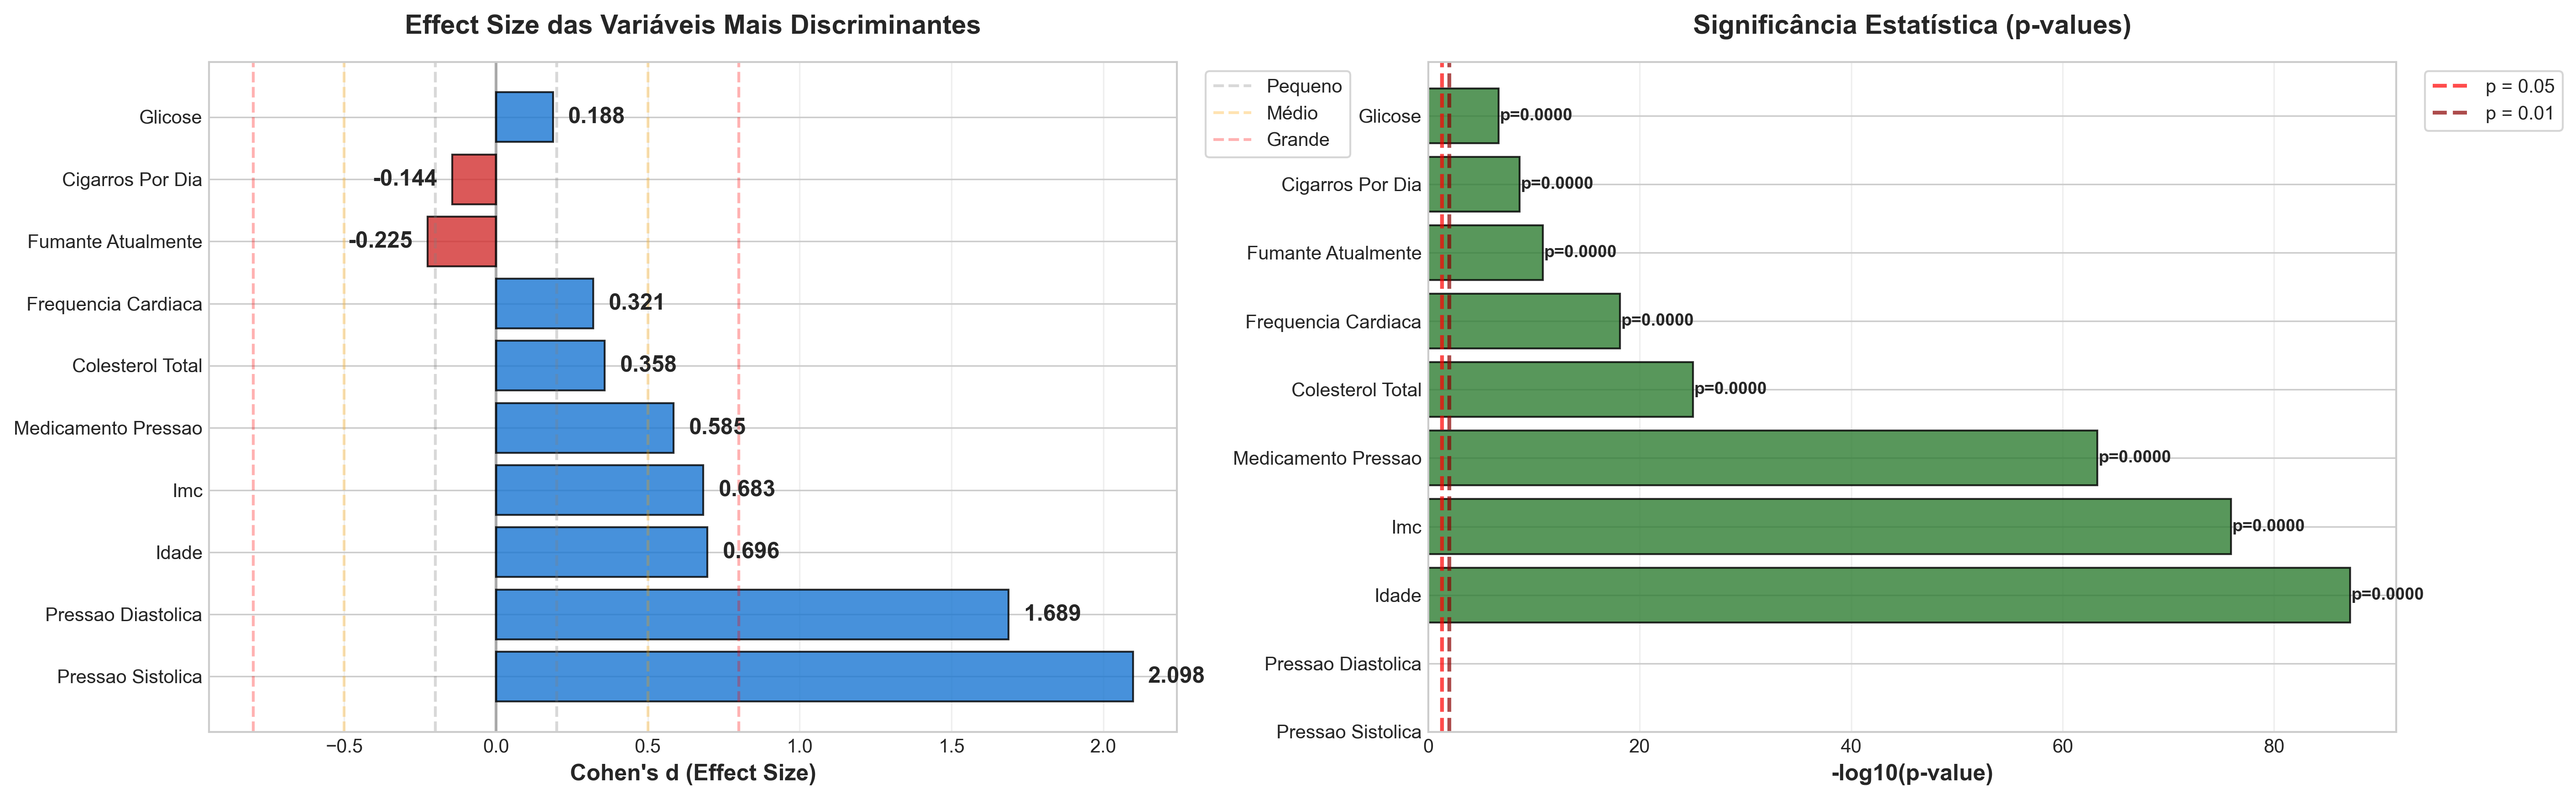


💡 INTERPRETAÇÃO:
   • Barras mais longas no gráfico da esquerda = maior diferença entre grupos
   • Barras à direita da linha vermelha no gráfico da direita = estatisticamente significativo
   • -log10(p-value) > 1.3 corresponde a p < 0.05 (significativo)
   • -log10(p-value) > 2.0 corresponde a p < 0.01 (altamente significativo)


In [17]:
# Visualização dos resultados estatísticos
if len(df_stats) > 0:
    print_section("VISUALIZAÇÃO DOS TESTES ESTATÍSTICOS")
    
    # Filtrar variáveis significativas
    df_stats_sig = df_stats[df_stats['significativo'] == 'Sim'].head(10)
    
    if len(df_stats_sig) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
        
        # Gráfico 1: Cohen's d para variáveis significativas
        colors_cohens = ['#d32f2f' if x < 0 else '#1976d2' for x in df_stats_sig['cohens_d']]
        bars1 = ax1.barh(range(len(df_stats_sig)), df_stats_sig['cohens_d'], 
                        color=colors_cohens, alpha=0.8, edgecolor='black')
        
        ax1.set_yticks(range(len(df_stats_sig)))
        ax1.set_yticklabels([v.replace('_', ' ').title() for v in df_stats_sig['variavel']])
        ax1.set_xlabel("Cohen's d (Effect Size)", fontweight='bold')
        ax1.set_title('Effect Size das Variáveis Mais Discriminantes', fontweight='bold', pad=15)
        ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        ax1.axvline(x=0.2, color='gray', linestyle='--', alpha=0.3, label='Pequeno')
        ax1.axvline(x=-0.2, color='gray', linestyle='--', alpha=0.3)
        ax1.axvline(x=0.5, color='orange', linestyle='--', alpha=0.3, label='Médio')
        ax1.axvline(x=-0.5, color='orange', linestyle='--', alpha=0.3)
        ax1.axvline(x=0.8, color='red', linestyle='--', alpha=0.3, label='Grande')
        ax1.axvline(x=-0.8, color='red', linestyle='--', alpha=0.3)
        ax1.legend(loc='lower right')
        ax1.grid(axis='x', alpha=0.3)
        
        # Adicionar valores
        for i, (bar, value) in enumerate(zip(bars1, df_stats_sig['cohens_d'])):
            ax1.text(value + (0.05 if value > 0 else -0.05), i, f'{value:.3f}', 
                    va='center', ha='left' if value > 0 else 'right', fontweight='bold')
        
        # Gráfico 2: P-values (escala logarítmica)
        p_values_log = -np.log10(df_stats_sig['p_value'])
        bars2 = ax2.barh(range(len(df_stats_sig)), p_values_log, 
                        color='#2E7D32', alpha=0.8, edgecolor='black')
        
        ax2.set_yticks(range(len(df_stats_sig)))
        ax2.set_yticklabels([v.replace('_', ' ').title() for v in df_stats_sig['variavel']])
        ax2.set_xlabel('-log10(p-value)', fontweight='bold')
        ax2.set_title('Significância Estatística (p-values)', fontweight='bold', pad=15)
        ax2.axvline(x=-np.log10(0.05), color='red', linestyle='--', 
                   alpha=0.7, linewidth=2, label='p = 0.05')
        ax2.axvline(x=-np.log10(0.01), color='darkred', linestyle='--', 
                   alpha=0.7, linewidth=2, label='p = 0.01')
        ax2.legend()
        ax2.grid(axis='x', alpha=0.3)
        
        # Adicionar valores
        for i, (bar, value, p_val) in enumerate(zip(bars2, p_values_log, df_stats_sig['p_value'])):
            ax2.text(value + 0.1, i, f'p={p_val:.4f}', 
                    va='center', ha='left', fontweight='bold', fontsize=9)
        
        plt.tight_layout()
        save_figure(fig, 'statistical_tests_results', 'eda')
        plt.show()
        
        print("\n💡 INTERPRETAÇÃO:")
        print("   • Barras mais longas no gráfico da esquerda = maior diferença entre grupos")
        print("   • Barras à direita da linha vermelha no gráfico da direita = estatisticamente significativo")
        print("   • -log10(p-value) > 1.3 corresponde a p < 0.05 (significativo)")
        print("   • -log10(p-value) > 2.0 corresponde a p < 0.01 (altamente significativo)")


## 10. Análise de Multicolinearidade (VIF)

O **Variance Inflation Factor (VIF)** identifica features redundantes que possuem alta correlação entre si.

**Interpretação do VIF:**
- VIF = 1: Sem correlação com outras variáveis
- VIF < 5: Correlação aceitável
- VIF entre 5-10: Correlação moderada (atenção)
- VIF > 10: Multicolinearidade alta (considerar remover)

In [18]:
print_section("ANÁLISE DE MULTICOLINEARIDADE (VIF)")

def calcular_vif(df, features, target_col=None):
    """
    Calcula VIF para identificar multicolinearidade entre features
    
    VIF (Variance Inflation Factor) mede o quanto a variância de um coeficiente
    de regressão é inflada devido à multicolinearidade com outras variáveis.
    """
    # Remover target das features se presente
    if target_col and target_col in features:
        features = [f for f in features if f != target_col]
    
    # Criar dataset apenas com features numéricas e sem valores ausentes
    df_vif = df[features].copy()
    
    # Remover colunas com valores ausentes para VIF
    df_vif = df_vif.dropna()
    
    if len(df_vif) < 10:
        print("⚠️ Dados insuficientes após remover valores ausentes")
        return None
    
    print(f"📊 Calculando VIF para {len(features)} variáveis...")
    print(f"   Usando {len(df_vif):,} observações completas\n")
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features
    
    # Calcular VIF para cada feature
    vif_values = []
    for i in range(len(features)):
        try:
            vif = variance_inflation_factor(df_vif.values, i)
            vif_values.append(vif)
        except Exception as e:
            print(f"⚠️ Erro ao calcular VIF para {features[i]}: {e}")
            vif_values.append(np.nan)
    
    vif_data["VIF"] = vif_values
    vif_data = vif_data.sort_values('VIF', ascending=False)
    
    # Classificar nível de multicolinearidade
    def classificar_vif(vif):
        if pd.isna(vif):
            return "Erro"
        elif vif < 5:
            return "Aceitável"
        elif vif < 10:
            return "Moderado"
        else:
            return "Alto"
    
    vif_data['Nível'] = vif_data['VIF'].apply(classificar_vif)
    
    print("="*70)
    print("RESULTADOS DA ANÁLISE VIF")
    print("="*70)
    print("\n📋 Interpretação dos valores:")
    print("   VIF = 1     → Sem correlação com outras variáveis")
    print("   VIF < 5     → Correlação aceitável")
    print("   VIF 5-10    → Correlação moderada (atenção)")
    print("   VIF > 10    → Multicolinearidade alta (considerar remover)")
    print("\n" + "="*70)
    
    display(vif_data.round(2))
    
    # Análise e recomendações
    problema_alto = vif_data[vif_data['VIF'] > 10]
    problema_moderado = vif_data[(vif_data['VIF'] >= 5) & (vif_data['VIF'] <= 10)]
    aceitavel = vif_data[vif_data['VIF'] < 5]
    
    print(f"\n📊 RESUMO:")
    print("="*70)
    print(f"   ✅ Features com VIF aceitável (< 5): {len(aceitavel)}")
    print(f"   ⚠️  Features com VIF moderado (5-10): {len(problema_moderado)}")
    print(f"   🔴 Features com VIF alto (> 10): {len(problema_alto)}")
    
    if len(problema_alto) > 0:
        print(f"\n🔴 FEATURES COM MULTICOLINEARIDADE ALTA (VIF > 10):")
        print("="*70)
        for idx, row in problema_alto.iterrows():
            print(f"   • {row['Feature'].replace('_', ' ').title()}: VIF = {row['VIF']:.2f}")
        
        print(f"\n💡 RECOMENDAÇÕES:")
        print("   1. Considere remover uma das variáveis altamente correlacionadas")
        print("   2. Ou combine-as através de PCA ou feature engineering")
        print("   3. Verifique a matriz de correlação para identificar pares problemáticos")
    
    if len(problema_moderado) > 0:
        print(f"\n⚠️  FEATURES COM MULTICOLINEARIDADE MODERADA (VIF 5-10):")
        print("="*70)
        for idx, row in problema_moderado.iterrows():
            print(f"   • {row['Feature'].replace('_', ' ').title()}: VIF = {row['VIF']:.2f}")
        
        print(f"\n💡 RECOMENDAÇÃO:")
        print("   • Monitorar estas variáveis durante a modelagem")
        print("   • Avaliar se a remoção melhora o desempenho do modelo")
    
    if len(problema_alto) == 0 and len(problema_moderado) == 0:
        print(f"\n✅ EXCELENTE: Todas as features possuem VIF aceitável!")
        print("   Não há problemas significativos de multicolinearidade")
    
    return vif_data

# Aplicar análise VIF
if 'continuous_features' in globals() and len(continuous_features) > 1:
    # Usar apenas features contínuas para VIF (variáveis categóricas binárias podem distorcer resultados)
    df_vif = calcular_vif(df, continuous_features, target_col)
else:
    print("⚠️ Insuficientes variáveis contínuas para análise VIF")
    df_vif = None



 ANÁLISE DE MULTICOLINEARIDADE (VIF)
📊 Calculando VIF para 8 variáveis...
   Usando 3,802 observações completas

RESULTADOS DA ANÁLISE VIF

📋 Interpretação dos valores:
   VIF = 1     → Sem correlação com outras variáveis
   VIF < 5     → Correlação aceitável
   VIF 5-10    → Correlação moderada (atenção)
   VIF > 10    → Multicolinearidade alta (considerar remover)



,Feature,VIF,Nível
4,pressao_diastolica,128.04,Alto
3,pressao_sistolica,112.08,Alto
5,imc,44.03,Alto
0,idade,39.48,Alto
6,frequencia_cardiaca,35.64,Alto
2,colesterol_total,30.25,Alto
7,glicose,12.92,Alto
1,cigarros_por_dia,1.60,Aceitável



📊 RESUMO:
   ✅ Features com VIF aceitável (< 5): 1
   ⚠️  Features com VIF moderado (5-10): 0
   🔴 Features com VIF alto (> 10): 7

🔴 FEATURES COM MULTICOLINEARIDADE ALTA (VIF > 10):
   • Pressao Diastolica: VIF = 128.04
   • Pressao Sistolica: VIF = 112.08
   • Imc: VIF = 44.03
   • Idade: VIF = 39.48
   • Frequencia Cardiaca: VIF = 35.64
   • Colesterol Total: VIF = 30.25
   • Glicose: VIF = 12.92

💡 RECOMENDAÇÕES:
   1. Considere remover uma das variáveis altamente correlacionadas
   2. Ou combine-as através de PCA ou feature engineering
   3. Verifique a matriz de correlação para identificar pares problemáticos



 VISUALIZAÇÃO DA ANÁLISE VIF
Figura salva em: C:\Users\Anderson\Downloads\tcc_hipertensao_arquivos\trabalho_tcc_mod_classifc_hipertensao-master\trabalho_tcc_mod_classifc_hipertensao-master\04_reports\figures\eda\vif_analysis


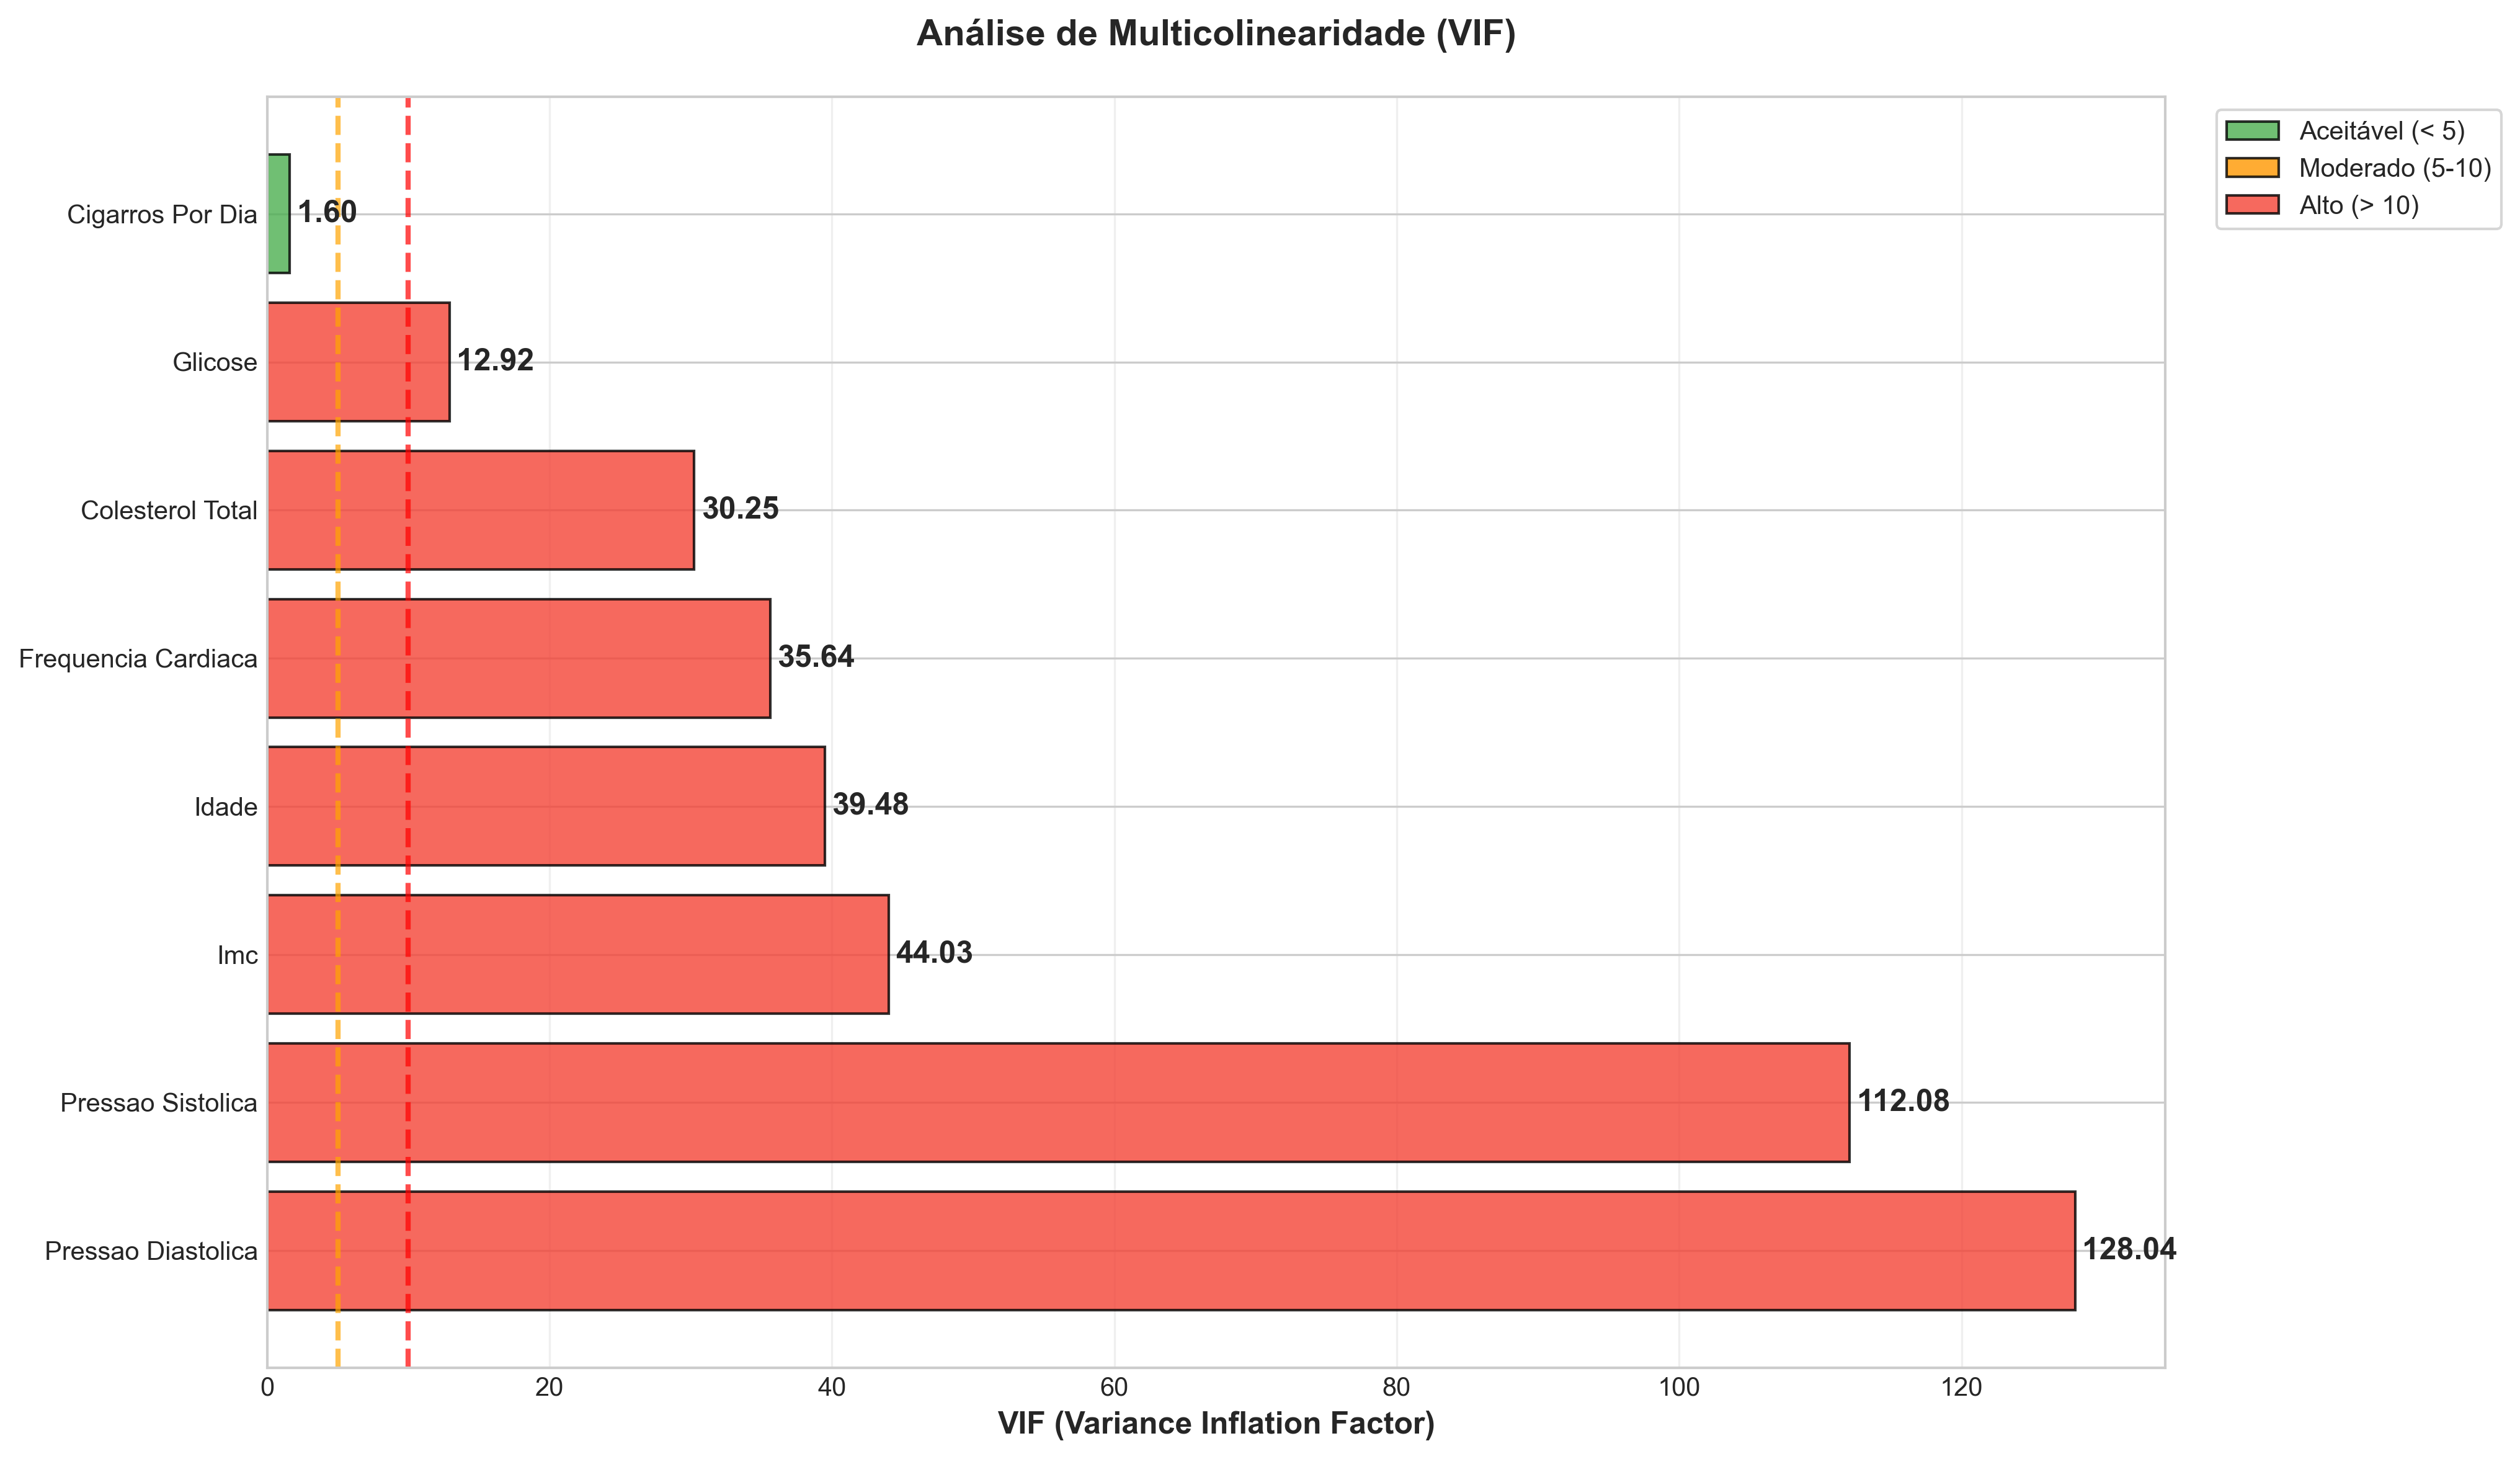


💡 INTERPRETAÇÃO DO GRÁFICO:
   • Barras verdes: Features sem problemas de multicolinearidade
   • Barras laranjas: Atenção - possível correlação entre features
   • Barras vermelhas: Problema - alta correlação, considere remover


In [19]:
# Visualização dos resultados VIF
if df_vif is not None and len(df_vif) > 0:
    print_section("VISUALIZAÇÃO DA ANÁLISE VIF")
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Definir cores baseadas no nível de VIF
    colors = []
    for vif in df_vif['VIF']:
        if pd.isna(vif):
            colors.append('gray')
        elif vif < 5:
            colors.append('#4CAF50')  # Verde - aceitável
        elif vif < 10:
            colors.append('#FF9800')  # Laranja - moderado
        else:
            colors.append('#F44336')  # Vermelho - alto
    
    bars = ax.barh(range(len(df_vif)), df_vif['VIF'], color=colors, alpha=0.8, edgecolor='black')
    
    ax.set_yticks(range(len(df_vif)))
    ax.set_yticklabels([f.replace('_', ' ').title() for f in df_vif['Feature']])
    ax.set_xlabel('VIF (Variance Inflation Factor)', fontweight='bold', fontsize=12)
    ax.set_title('Análise de Multicolinearidade (VIF)', fontweight='bold', fontsize=14, pad=20)
    
    # Linhas de referência
    ax.axvline(x=5, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='VIF = 5 (Limite aceitável)')
    ax.axvline(x=10, color='red', linestyle='--', alpha=0.7, linewidth=2, label='VIF = 10 (Limite crítico)')
    
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(axis='x', alpha=0.3)
    
    # Adicionar valores nas barras
    for i, (bar, value) in enumerate(zip(bars, df_vif['VIF'])):
        if not pd.isna(value):
            ax.text(value + 0.5, i, f'{value:.2f}', 
                   va='center', ha='left', fontweight='bold')
    
    # Adicionar legenda de cores
    from matplotlib.patches import Rectangle
    legend_elements = [
        Rectangle((0, 0), 1, 1, fc='#4CAF50', alpha=0.8, edgecolor='black', label='Aceitável (< 5)'),
        Rectangle((0, 0), 1, 1, fc='#FF9800', alpha=0.8, edgecolor='black', label='Moderado (5-10)'),
        Rectangle((0, 0), 1, 1, fc='#F44336', alpha=0.8, edgecolor='black', label='Alto (> 10)')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    plt.tight_layout()
    save_figure(fig, 'vif_analysis', 'eda')
    plt.show()
    
    print("\n💡 INTERPRETAÇÃO DO GRÁFICO:")
    print("   • Barras verdes: Features sem problemas de multicolinearidade")
    print("   • Barras laranjas: Atenção - possível correlação entre features")
    print("   • Barras vermelhas: Problema - alta correlação, considere remover")


## 11. Resumo Executivo

In [20]:
print_section("RESUMO EXECUTIVO DA ANÁLISE EXPLORATÓRIA", "=", 100)

print("🎯 PRINCIPAIS DESCOBERTAS:")
print("="*50)

# Informações do dataset
print(f"📊 Dataset: {df.shape[0]:,} pacientes com {df.shape[1]} variáveis")
if 'categorical_features' in globals():
    print(f"   🏷️  Variáveis categóricas: {len(categorical_features)}")
if 'continuous_features' in globals():
    print(f"   📈 Variáveis contínuas: {len(continuous_features)}")

# Target
if 'class_distribution' in globals() and len(class_distribution) >= 2:
    print(f"🎯 Target: {class_distribution.iloc[1]:,} alto risco ({class_percentages.iloc[1]:.1f}%) vs {class_distribution.iloc[0]:,} baixo risco ({class_percentages.iloc[0]:.1f}%)")

# Análise estatística
if 'df_stats' in globals() and len(df_stats) > 0:
    vars_sig = len(df_stats[df_stats['significativo'] == 'Sim'])
    print(f"\n🔬 ANÁLISE ESTATÍSTICA:")
    print(f"   ✅ {vars_sig} variáveis com diferença estatisticamente significativa")
    
    if vars_sig > 0:
        top_3_vars = df_stats[df_stats['significativo'] == 'Sim'].head(3)
        print(f"\n   🏆 TOP 3 VARIÁVEIS MAIS DISCRIMINANTES:")
        for i, (idx, row) in enumerate(top_3_vars.iterrows(), 1):
            print(f"      {i}. {row['variavel'].replace('_', ' ').title()} (Cohen's d = {row['cohens_d']:.3f}, p = {row['p_value']:.4f})")

# VIF
if 'df_vif' in globals() and df_vif is not None:
    problema_vif = len(df_vif[df_vif['VIF'] > 10])
    print(f"\n🔗 MULTICOLINEARIDADE:")
    if problema_vif == 0:
        print(f"   ✅ Nenhuma feature com VIF crítico (> 10)")
    else:
        print(f"   ⚠️  {problema_vif} features com VIF > 10 (multicolinearidade alta)")
        high_vif_vars = df_vif[df_vif['VIF'] > 10]['Feature'].tolist()
        print(f"      Features: {', '.join([v.replace('_', ' ').title() for v in high_vif_vars])}")

# Recomendações
print(f"\n💡 RECOMENDAÇÕES PARA PRÉ-PROCESSAMENTO:")
print("="*50)

recomendacoes_count = 0

if 'df_stats' in globals() and len(df_stats) > 0:
    recomendacoes_count += 1
    print(f"  {recomendacoes_count}. 🎯 Priorizar features com alto effect size e significância estatística")
    top_features = df_stats[df_stats['significativo'] == 'Sim'].head(5)['variavel'].tolist()
    if top_features:
        print(f"     Focar em: {', '.join([f.replace('_', ' ').title() for f in top_features[:3]])}")

if 'df_vif' in globals() and df_vif is not None:
    high_vif = df_vif[df_vif['VIF'] > 10]
    if len(high_vif) > 0:
        recomendacoes_count += 1
        print(f"  {recomendacoes_count}. 🔗 Tratar multicolinearidade nas features com VIF > 10")
        print(f"     Considerar PCA ou remoção seletiva")

if 'imbalance_ratio' in globals():
    if imbalance_ratio > 2:
        recomendacoes_count += 1
        print(f"  {recomendacoes_count}. ⚖️  Aplicar técnicas de balanceamento (SMOTE recomendado)")

recomendacoes_count += 1
print(f"  {recomendacoes_count}. 🔄 Aplicar normalização/padronização considerando distribuições identificadas")

recomendacoes_count += 1
print(f"  {recomendacoes_count}. 📊 Feature engineering baseado em variáveis com alto poder discriminante")

print(f"\n{'='*100}")
print("✅ ANÁLISE EXPLORATÓRIA AVANÇADA CONCLUÍDA COM SUCESSO!")
print("="*100)
print(f"\n🎯 Próxima etapa: Pré-processamento de dados (notebook 02)")
print(f"   Use os insights estatísticos para guiar as decisões de pré-processamento")
print("="*100)



 RESUMO EXECUTIVO DA ANÁLISE EXPLORATÓRIA
🎯 PRINCIPAIS DESCOBERTAS:
📊 Dataset: 4,240 pacientes com 13 variáveis
   🏷️  Variáveis categóricas: 4
   📈 Variáveis contínuas: 8
🎯 Target: 1,317 alto risco (31.1%) vs 2,923 baixo risco (68.9%)

🔬 ANÁLISE ESTATÍSTICA:
   ✅ 11 variáveis com diferença estatisticamente significativa

   🏆 TOP 3 VARIÁVEIS MAIS DISCRIMINANTES:
      1. Pressao Sistolica (Cohen's d = 2.098, p = 0.0000)
      2. Pressao Diastolica (Cohen's d = 1.689, p = 0.0000)
      3. Idade (Cohen's d = 0.696, p = 0.0000)

🔗 MULTICOLINEARIDADE:
   ⚠️  7 features com VIF > 10 (multicolinearidade alta)
      Features: Pressao Diastolica, Pressao Sistolica, Imc, Idade, Frequencia Cardiaca, Colesterol Total, Glicose

💡 RECOMENDAÇÕES PARA PRÉ-PROCESSAMENTO:
  1. 🎯 Priorizar features com alto effect size e significância estatística
     Focar em: Pressao Sistolica, Pressao Diastolica, Idade
  2. 🔗 Tratar multicolinearidade nas features com VIF > 10
     Considerar PCA ou remoção seletiv

## 12.  Próximos Passos

---
### Melhorias Implementadas ✅
1. **Análise Estatística Aprofundada**
   - Testes Mann-Whitney U para variáveis contínuas
   - Cálculo de Cohen's d (effect size)
   - Identificação de variáveis estatisticamente significativas

2. **Análise de Multicolinearidade (VIF)**
   - Cálculo do Variance Inflation Factor
   - Identificação de features redundantes
   - Recomendações para tratamento

### Recomendações para Notebooks Seguintes

1. **Pré-processamento** (`02_data_preprocessing.ipynb`)
   - Usar insights das análises estatísticas
   - Tratar features com alto VIF
   - Balanceamento guiado por effect sizes

2. **Feature Engineering** (`03_feature_engineering.ipynb`)
   - Priorizar features com alto Cohen's d
   - Considerar PCA para features colineares
   - Criar interações baseadas em significância estatística

3. **Modelagem** (`04_model_training.ipynb`)
   - Usar features estatisticamente validadas
   - Monitorar impact de features com VIF moderado